## Выбор модели для задач классификации

Для задач классификации существует несколько способов выбора модели:

1. **Обучить маленькую модель с нуля**: Выбор легковесной архитектуры модели и полное обучение её на нашем наборе данных.
2. **Fine-Tuning предобученной модели**: Используем модель, которая была предобучена авторами на другом наборе данных, и только последние слои переобучается на нашем конкретном наборе данных.
3. **Использовать предобученные веса напрямую**: В этом методе используется предобученная модель без дополнительного обучения.

Лучшим вариантом является Fine-Tuning, поэтому в качестве бейзлайна возьмем маленькую (5.3M) EfficientNet B0 с претрейновыми параметрами

[Оригинальная статья](https://arxiv.org/abs/1905.11946)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import json
import shutil
import time

# Предобработка данных

In [ ]:
directory_path = '/content/dataset'

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Директория {directory_path} успешно удалена.")
else:
    print(f"Директория {directory_path} не существует.")

Директория /content/dataset не существует.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# drive.flush_and_unmount()

In [ ]:
# Загрузка гиперпараметров из JSON (создайте папку classification, если её еще нет в корне диска Google Drive)
with open('/content/drive/MyDrive/classification/hyperparams.json', "r") as f:
  hyperparams = json.load(f)

In [ ]:
# Загрузка названий классов из JSON
with open("/content/drive/MyDrive/classification/class_to_idx.json", "r")  as f:
  class_to_idx = json.load(f)


**Структура** c*lassification_dataset.zip*: (внутри папка с таким же названием)

```
classification_dataset/
├── train/
│   ├── class_name1/
│   └── class_name2/
│   └── ...

└── test/
    ├── class_name1/
    └── class_name2/
    └── ...
```



In [ ]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
# Класс для аугментации данных
class AugmentedDataset(Dataset):
    def __init__(self, original_folder, target_size=50, transform=None):
        self.transform = transform
        self.samples = []
        self.class_to_idx = class_to_idx

        # Проверяем, что все классы из JSON есть в папке
        class_names = os.listdir(original_folder)
        missing_classes = [cls for cls in class_to_idx.keys() if cls not in class_names]
        if missing_classes:
            raise ValueError(f"Классы {missing_classes} из class_to_idx.json отсутствуют в папке {original_folder}")

        # Собираем пути к изображениям для каждого класса
        for class_name in class_names: # Используем отсортированные имена классов
            class_path = os.path.join(original_folder, class_name)
            images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
            # Повторяем изображения до достижения целевого размера
            for i in range(target_size):
                self.samples.append((images[i % len(images)], class_name))

    # Возвращает общее количество элементов в наборе данных
    def __len__(self):
        return len(self.samples)

    # Возвращает одно изображение и его метку по индексу
    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        # Применяем аугментации
        if self.transform:
            image = self.transform(image)

        # Преобразуем метку класса в числовой формат
        label = self.class_to_idx[class_name]  # Преобразуем имя класса в индекс
        return image, label  # Оставляем числовую метку для обучения

In [ ]:
# Класс для создания датасета под Test выборку
class TestDataset(Dataset):
    def __init__(self, original_folder, transform=None):
        self.transform = transform
        self.samples = []
        self.class_to_idx = class_to_idx  # Загружаем метки классов из JSON

        # Проверяем, что все классы из JSON есть в папке
        class_names = os.listdir(original_folder)
        missing_classes = [cls for cls in class_to_idx.keys() if cls not in class_names]
        if missing_classes:
            raise ValueError(f"Классы {missing_classes} из class_to_idx.json отсутствуют в {original_folder}")

        # Собираем пути к изображениям
        for class_name in class_names:
            class_path = os.path.join(original_folder, class_name)
            images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
            for img_path in images:
                self.samples.append((img_path, class_name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        # Применяем трансформации (без аугментаций)
        if self.transform:
            image = self.transform(image)

        # Преобразуем имя класса в индекс
        label = self.class_to_idx[class_name]
        return image, label

In [ ]:
def create_dataloaders(
    train_dir,
    test_dir,
    hyperparams,
    target_size=50,
    image_size=224
):
    """
    Создает DataLoader'ы для обучающих и тестовых данных.

    Args:
        train_dir: Путь к папке с обучающими данными.
        test_dir: Путь к папке с тестовыми данными.
        hyperparams: Словарь с гиперпараметрами, включая 'batch_size'.
        target_size: Целевой размер для аугментации данных.
        image_size: Размер, до которого будут изменяться изображения (width, height).

    Returns:
        train_loader, test_loader, train_dataset, test_dataset: DataLoader'ы и датасеты для обучающих и тестовых данных.
    """

    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Создание аугментированных датасетов
    train_dataset = AugmentedDataset(
        original_folder=train_dir,
        target_size=target_size,
        transform=train_transform
    )

    test_dataset = TestDataset(
        original_folder=test_dir,
        transform=test_transform
    )

    # DataLoader'ы
    train_loader = DataLoader(
        train_dataset,
        batch_size=hyperparams['batch_size'],
        shuffle=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=hyperparams['batch_size'],
        shuffle=False
    )

    return train_loader, test_loader, train_dataset, test_dataset

In [ ]:
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(
    train_dir='/content/dataset/classification_dataset/train',
    test_dir='/content/dataset/classification_dataset/test',
    hyperparams=hyperparams,
    target_size=50,
    image_size=224
)

In [ ]:
# Проверим классы
test_dataset.class_to_idx

{'dog': 0, 'cat': 1}

In [ ]:
# Создание обратного словаря idx_to_class
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Загрузка модели (EfficentNet B0)

In [ ]:
# Загрузка модели EfficientNet
model = efficientnet_b0(EfficientNet_B0_Weights.DEFAULT)

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Замена финального классификатора
num_features = model.classifier[1].in_features
num_classes = len(class_to_idx)  # Количество классов из JSON
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Многоклассовая классификация
    # На выходе оставляем сырые логиты, так как nn.CrossEntropyLoss() их ожидает на вход
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 185MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)

# Функции метрик и визуализации

### Фунция для расчета метрик классификации

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [ ]:
def evaluate_model(model, data_loader, criterion, device):
  """
  Оценивает модель, возвращая словарь различных метрик
  (Accuracy, f1_Score, precision, recall etc.)
  """
  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []


  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item() * images.size(0)

      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())



    # Расчет метрик

    accuracy = correct / total
    avg_loss = val_loss / len(data_loader.dataset)


    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    class_report = classification_report(all_labels, all_preds, zero_division=0, output_dict=True)
    conf_matrix = confusion_matrix(all_labels, all_preds)



  return {
      'loss': avg_loss,
      'accuracy': accuracy,
      'f1_score': f1,
      'precision': precision,
      'recall': recall,
      'class_report': class_report,
      'confusion_matrix': conf_matrix,
      'predictions': all_preds,
      'ground_truth': all_labels
  }



### Функции для визуализации

In [ ]:
import seaborn as sns

In [ ]:
def plot_training_history(train_metrics, val_metrics, metric_name='loss'):
    """
    Строит графики выбранной метрики на протяжении эпох обучения.

    Args:
        train_metrics: Список значений метрики на обучающей выборке
        val_metrics: Список значений метрики на валидационной выборке
        metric_name: Название метрики для отображения
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics, 'b-', label=f'Тренировка {metric_name}')
    plt.plot(epochs, val_metrics, 'r-', label=f'Валидация {metric_name}')

    plt.title(f'Тренировка и валидация {metric_name.capitalize()}')
    plt.xlabel('Эпохи')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(cm, class_names):
    """
    Визуализирует матрицу ошибок.

    Args:
        cm: Матрица ошибок
        class_names: Список названий классов
    """
    plt.figure(figsize=(10, 8))

    cm_normalized = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title('Нормализованная матрица ошибок')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, test_dataset, idx_to_class, device, num_samples=10):
    """
    Визуализирует предсказания модели на тестовых примерах.

    Args:
        model: Обученная модель
        test_dataset: Тестовый датасет
        idx_to_class: Словарь для преобразования индекса класса в название
        device: Устройство для выполнения вычислений
        num_samples: Количество примеров для визуализации
    """
    model.eval()

    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    fig, axes = plt.subplots(2, num_samples // 2, figsize=(20, 8))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        image, label = test_dataset[idx]

        img = image.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            _, predicted = torch.max(output, 1)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence = probabilities[0][predicted[0]].item()

        axes[i].imshow(img)
        title_color = 'green' if predicted[0].item() == label else 'red'

        axes[i].set_title(f"Predicted: {idx_to_class[predicted[0].item()]}\n"
                         f"True: {idx_to_class[label]}\n"
                         f"Conf: {confidence:.2f}", color=title_color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_class_distribution(train_dataset, test_dataset, idx_to_class):
    """
    Визуализирует распределение классов в обучающем и тестовом наборах.
    """
    train_counts = {}
    test_counts = {}

    for _, label_name in train_dataset.samples:
        label = train_dataset.class_to_idx[label_name]
        train_counts[label] = train_counts.get(label, 0) + 1

    for _, label_name in test_dataset.samples:
        label = test_dataset.class_to_idx[label_name]
        test_counts[label] = test_counts.get(label, 0) + 1

    class_indices = sorted(idx_to_class.keys())
    class_names = [idx_to_class[i] for i in class_indices]

    train_values = [train_counts.get(i, 0) for i in class_indices]
    test_values = [test_counts.get(i, 0) for i in class_indices]

    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(class_indices))
    width = 0.35

    ax.bar(x - width/2, train_values, width, label='Train')
    ax.bar(x + width/2, test_values, width, label='Test')

    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_title('Распределение классов в наборах данных')
    ax.set_ylabel('Количество изображений')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Обучение моделей EfficentNet

### Обучение модели (B0)

Нейминг: `modelname_weight_inf_samples(N)`

`N - Unknown classes`

In [ ]:
def log_gpu_memory(message="", reset_max=False):
    """
    Логирует текущее и максимальное использование GPU-памяти

    Args:
        message: Сообщение для логирования
        reset_max: Сбросить счетчик максимального использования
    """
    if torch.cuda.is_available():
        current_mem = torch.cuda.memory_allocated() / (1024 ** 2)  # МБ
        max_mem = torch.cuda.max_memory_allocated() / (1024 ** 2)  # МБ
        print(f"{message} - Текущая память GPU: {current_mem:.2f} МБ, Пиковая память: {max_mem:.2f} МБ")
        if reset_max:
            torch.cuda.reset_max_memory_allocated()
    else:
        print("CUDA недоступна")

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_f1': [],
        'precision': [],
        'recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0


        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_correct / train_total

        metrics = evaluate_model(model, test_loader, criterion, device)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(metrics['loss'])
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(metrics['accuracy'])
        history['val_f1'].append(metrics['f1_score'])

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(
            f"Val Loss: {metrics['loss']:.4f}, Val Acc: {metrics['accuracy']:.4f}, Val F1: {metrics['f1_score']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}"
            )
        print('-' * 60)

    return history, model

In [ ]:
# @title Текущее потребление памяти
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Максимальный объем памяти = {max_memory} ГБ.")
print(f"{start_gpu_memory} ГБ памяти зарезервировано.")

GPU = Tesla T4. Максимальный объем памяти = 14.741 ГБ.
0.033 ГБ памяти зарезервировано.


In [ ]:
start_time = time.time()

efficientnet_b0_history_50, efficientnet_b0_50 = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)

train_runtime = time.time() - start_time

Epoch 1/10
Train Loss: 0.6765, Train Acc: 0.5900
Val Loss: 0.6440, Val Acc: 0.7590, Val F1: 0.7499, Precision: 0.8033, Recall: 0.7590
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.6143, Train Acc: 0.8500
Val Loss: 0.6054, Val Acc: 0.8320, Val F1: 0.8291, Precision: 0.8561, Recall: 0.8320
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.5653, Train Acc: 0.8400
Val Loss: 0.5661, Val Acc: 0.8530, Val F1: 0.8510, Precision: 0.8734, Recall: 0.8530
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.5269, Train Acc: 0.8900
Val Loss: 0.5314, Val Acc: 0.8960, Val F1: 0.8956, Precision: 0.9026, Recall: 0.8960
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.5015, Train Acc: 0.8500
Val Loss: 0.4951, Val Acc: 0.8750, Val F1: 0.8739, Precision: 0.8884, Recall: 0.8750
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [ ]:
# @title Потребление памяти после обучения
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_training = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
training_percentage = round(used_memory_for_training / max_memory * 100, 3)

# Выводим статистику
print(f"{train_runtime} секунд затрачено на обучение.")
print(
    f"{round(train_runtime/60, 2)} минут затрачено на обучение."
)
print(f"Пиковый объем зарезервированной памяти = {used_memory} ГБ.")
print(f"Пиковый объем зарезервированной памяти для обучения = {used_memory_for_training} ГБ.")
print(f"Пиковый объем зарезервированной памяти в % от максимальной памяти = {used_percentage} %.")
print(f"Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = {training_percentage} %.")

72.62968111038208 секунд затрачено на обучение.
1.21 минут затрачено на обучение.
Пиковый объем зарезервированной памяти = 0.178 ГБ.
Пиковый объем зарезервированной памяти для обучения = 0.145 ГБ.
Пиковый объем зарезервированной памяти в % от максимальной памяти = 1.208 %.
Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = 0.984 %.


In [ ]:
efficientnet_b0_metrics_50 = evaluate_model(efficientnet_b0_50, test_loader, criterion, device)

In [ ]:
efficientnet_b0_metrics_50["confusion_matrix"]

array([[438,  62],
       [ 23, 477]])

Довольно много примеров модель угадывает правильно даже при малом кол-ве сэмплов ( всего 50 на каждый класс )

In [ ]:
efficientnet_b0_metrics_50["class_report"]

{'0': {'precision': 0.9501084598698482,
  'recall': 0.876,
  'f1-score': 0.9115504682622269,
  'support': 500.0},
 '1': {'precision': 0.8849721706864564,
  'recall': 0.954,
  'f1-score': 0.9181905678537055,
  'support': 500.0},
 'accuracy': 0.915,
 'macro avg': {'precision': 0.9175403152781523,
  'recall': 0.915,
  'f1-score': 0.9148705180579662,
  'support': 1000.0},
 'weighted avg': {'precision': 0.9175403152781523,
  'recall': 0.915,
  'f1-score': 0.9148705180579662,
  'support': 1000.0}}

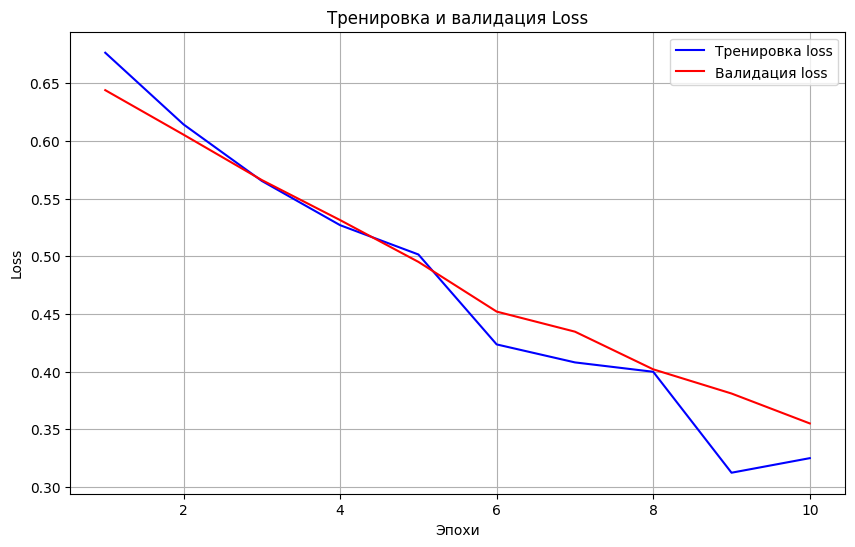

In [ ]:
plot_training_history(efficientnet_b0_history_50['train_loss'], efficientnet_b0_history_50['val_loss'], 'loss')

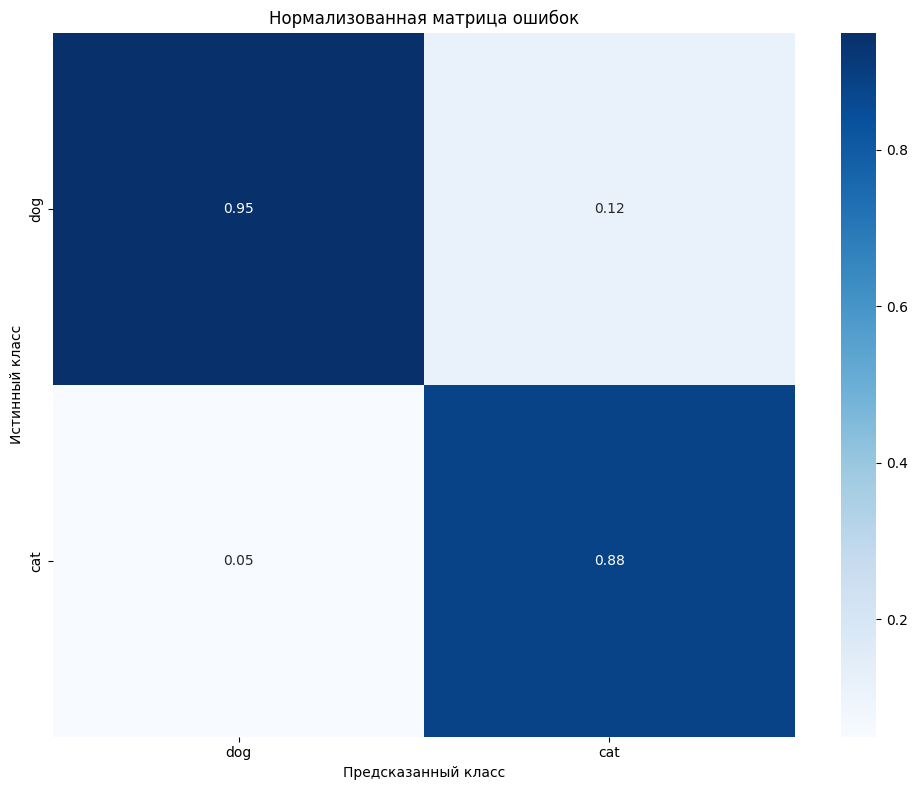

In [ ]:
plot_confusion_matrix(efficientnet_b0_metrics_50["confusion_matrix"], idx_to_class.values())

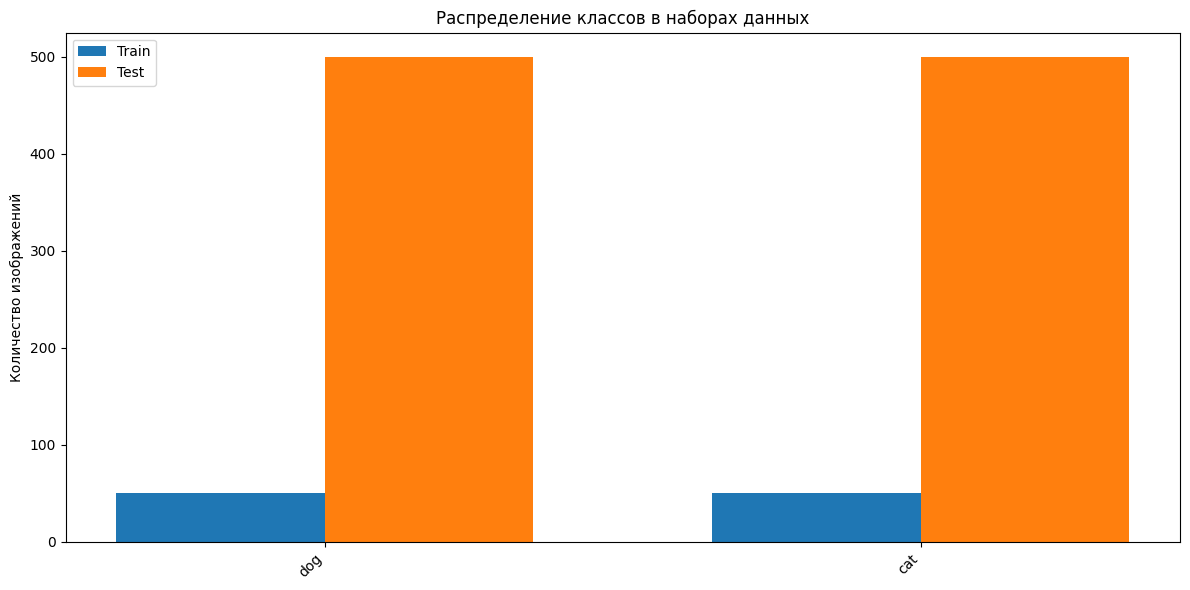

In [ ]:
plot_class_distribution(train_dataset, test_dataset, idx_to_class)

In [ ]:
benchmarks = {
    "efficientnet_b0_50": efficientnet_b0_metrics_50
}

Модель показывает отличные матрики на совсем малом кол-ве изображений в тренировочном датасете, попробуем снизить их до минимального кол-ва (15) по каждому из классов

*Сделаем замечание, что EfficentNet обучалась на датасете ImageNet, в котором уже присутсвовали данные классы, дальше попробуем обучаться на незнакомых модели классах*

In [ ]:
directory_path = '/content/dataset'

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Директория {directory_path} успешно удалена.")
else:
    print(f"Директория {directory_path} не существует.")

Директория /content/dataset успешно удалена.


In [ ]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset_small.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(
    train_dir='/content/dataset/classification_dataset/train',
    test_dir='/content/dataset/classification_dataset/test',
    hyperparams=hyperparams,
    target_size=50,
    image_size=224
)

In [ ]:
# Загрузка модели EfficientNet
model = efficientnet_b0(EfficientNet_B0_Weights.DEFAULT)

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Замена финального классификатора
num_features = model.classifier[1].in_features
num_classes = len(class_to_idx)  # Количество классов из JSON
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Многоклассовая классификация
    # На выходе оставляем сырые логиты, так как nn.CrossEntropyLoss() их ожидает на вход
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)

In [ ]:
efficientnet_b0_history_15, efficientnet_b0_15 = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)

Epoch 1/10
Train Loss: 0.6789, Train Acc: 0.5800
Val Loss: 0.6494, Val Acc: 0.7820, Val F1: 0.7812, Precision: 0.7864, Recall: 0.7820
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.6107, Train Acc: 0.8500
Val Loss: 0.6168, Val Acc: 0.8460, Val F1: 0.8454, Precision: 0.8511, Recall: 0.8460
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.5526, Train Acc: 0.9300
Val Loss: 0.5835, Val Acc: 0.8710, Val F1: 0.8708, Precision: 0.8733, Recall: 0.8710
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.4895, Train Acc: 0.9500
Val Loss: 0.5543, Val Acc: 0.8720, Val F1: 0.8718, Precision: 0.8744, Recall: 0.8720
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.4524, Train Acc: 0.9300
Val Loss: 0.5155, Val Acc: 0.8940, Val F1: 0.8938, Precision: 0.8963, Recall: 0.8940
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [ ]:
efficientnet_b0_metrics_15 = evaluate_model(efficientnet_b0_15, test_loader, criterion, device)

In [ ]:
efficientnet_b0_metrics_15["confusion_matrix"]

array([[459,  41],
       [ 49, 451]])

In [ ]:
efficientnet_b0_metrics_15["class_report"]

{'0': {'precision': 0.9035433070866141,
  'recall': 0.918,
  'f1-score': 0.9107142857142857,
  'support': 500.0},
 '1': {'precision': 0.9166666666666666,
  'recall': 0.902,
  'f1-score': 0.9092741935483871,
  'support': 500.0},
 'accuracy': 0.91,
 'macro avg': {'precision': 0.9101049868766404,
  'recall': 0.91,
  'f1-score': 0.9099942396313364,
  'support': 1000.0},
 'weighted avg': {'precision': 0.9101049868766404,
  'recall': 0.91,
  'f1-score': 0.9099942396313363,
  'support': 1000.0}}

In [ ]:
benchmarks["efficientnet_b0_15"] = efficientnet_b0_metrics_15

In [ ]:
import pandas as pd

<Figure size 1400x800 with 0 Axes>

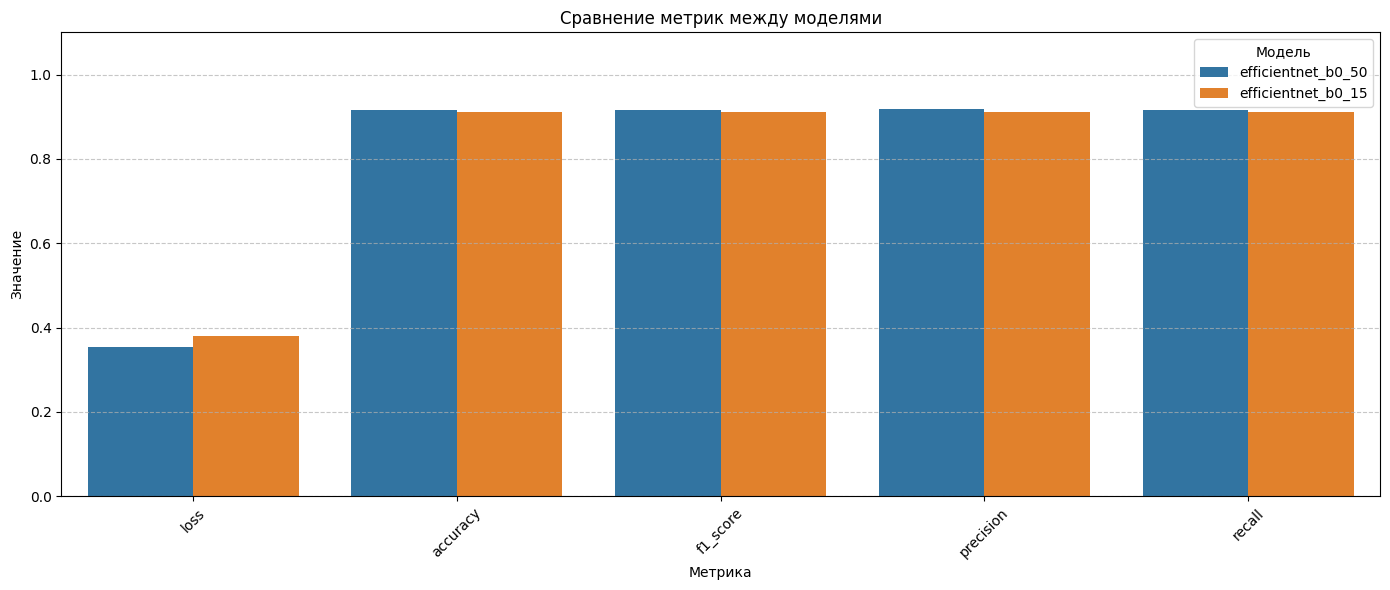

In [ ]:
def compare_benchmarks(benchmarks):
    """
    Сравнивает метрики между различными моделями в бенчмарке.

    Args:
        benchmarks: Словарь вида {имя_модели: словарь_метрик}
    """

    first_model = list(benchmarks.keys())[0]
    metrics_to_compare = [metric for metric, value in benchmarks[first_model].items()
                          if isinstance(value, (int, float)) and metric not in ['predictions', 'ground_truth']]

    comparison_data = []
    for model_name, metrics in benchmarks.items():
        model_data = {'Модель': model_name}
        for metric in metrics_to_compare:
            if metric in metrics and isinstance(metrics[metric], (int, float)):
                model_data[metric] = metrics[metric]
        comparison_data.append(model_data)

    df = pd.DataFrame(comparison_data)

    plt.figure(figsize=(14, 8))

    df_melted = df.melt(id_vars=['Модель'], var_name='Метрика', value_name='Значение')

    plt.figure(figsize=(14, 6))
    sns.barplot(x='Метрика', y='Значение', hue='Модель', data=df_melted)
    plt.title('Сравнение метрик между моделями')
    plt.ylabel('Значение')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.show()

    return None

comparison_df = compare_benchmarks(benchmarks)

Результаты немного ниже, теперь попробуем взять незнакомые классы

*Датасет с актерами Tom Hanks и Tom Cruise*

In [ ]:
# Загрузка новых названий классов из JSON
with open("/content/drive/MyDrive/classification/class_to_idx_celebrity.json", "r")  as f:
  class_to_idx = json.load(f)

In [ ]:
# Создание обратного словаря idx_to_class
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [ ]:
directory_path = '/content/dataset'

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Директория {directory_path} успешно удалена.")
else:
    print(f"Директория {directory_path} не существует.")

Директория /content/dataset успешно удалена.


In [ ]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset_selebrity.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(
    train_dir='/content/dataset/classification_dataset/train',
    test_dir='/content/dataset/classification_dataset/test',
    hyperparams=hyperparams,
    target_size=50,
    image_size=224
)

In [ ]:
# Загрузка модели EfficientNet
model = efficientnet_b0(EfficientNet_B0_Weights.DEFAULT)

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Замена финального классификатора
num_features = model.classifier[1].in_features
num_classes = len(class_to_idx)  # Количество классов из JSON
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Многоклассовая классификация
    # На выходе оставляем сырые логиты, так как nn.CrossEntropyLoss() их ожидает на вход
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)

In [ ]:
efficientnet_b0_history_15N, efficientnet_b0_15N = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)

Epoch 1/10
Train Loss: 0.6725, Train Acc: 0.5900
Val Loss: 0.6820, Val Acc: 0.6045, Val F1: 0.6003, Precision: 0.6153, Recall: 0.6045
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.6267, Train Acc: 0.9100
Val Loss: 0.6568, Val Acc: 0.7571, Val F1: 0.7570, Precision: 0.7570, Recall: 0.7571
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.5690, Train Acc: 0.9800
Val Loss: 0.6351, Val Acc: 0.7910, Val F1: 0.7896, Precision: 0.7945, Recall: 0.7910
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.5232, Train Acc: 0.9400
Val Loss: 0.6122, Val Acc: 0.7910, Val F1: 0.7879, Precision: 0.8181, Recall: 0.7910
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.4684, Train Acc: 0.9600
Val Loss: 0.5802, Val Acc: 0.8531, Val F1: 0.8531, Precision: 0.8551, Recall: 0.8531
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [ ]:
efficientnet_b0_metrics_15N = evaluate_model(efficientnet_b0_15N, test_loader, criterion, device)

In [ ]:
efficientnet_b0_metrics_15N["confusion_matrix"]

array([[60, 32],
       [ 3, 82]])

In [ ]:
efficientnet_b0_metrics_15N["class_report"]

{'0': {'precision': 0.9523809523809523,
  'recall': 0.6521739130434783,
  'f1-score': 0.7741935483870968,
  'support': 92.0},
 '1': {'precision': 0.7192982456140351,
  'recall': 0.9647058823529412,
  'f1-score': 0.8241206030150754,
  'support': 85.0},
 'accuracy': 0.8022598870056498,
 'macro avg': {'precision': 0.8358395989974937,
  'recall': 0.8084398976982097,
  'f1-score': 0.7991570757010861,
  'support': 177.0},
 'weighted avg': {'precision': 0.8404485790748056,
  'recall': 0.8022598870056498,
  'f1-score': 0.798169817558725,
  'support': 177.0}}

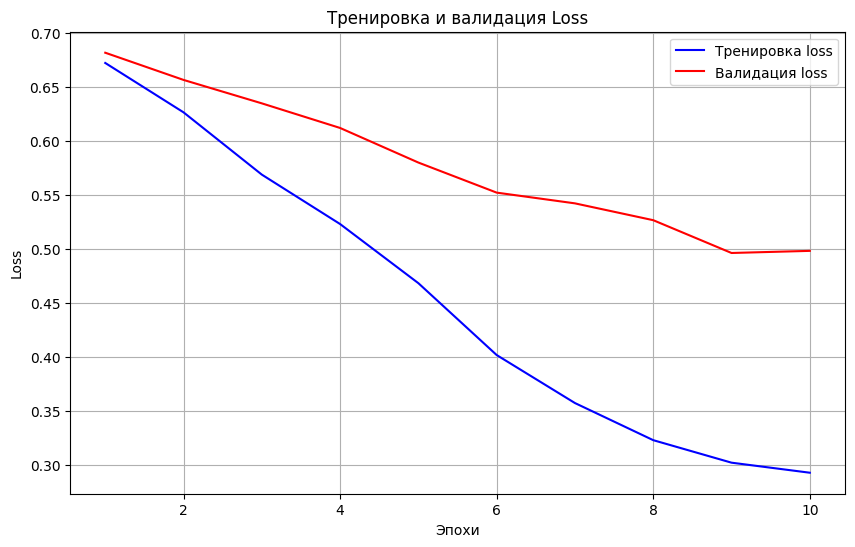

In [ ]:
plot_training_history(efficientnet_b0_history_15N['train_loss'], efficientnet_b0_history_15N['val_loss'], 'loss')

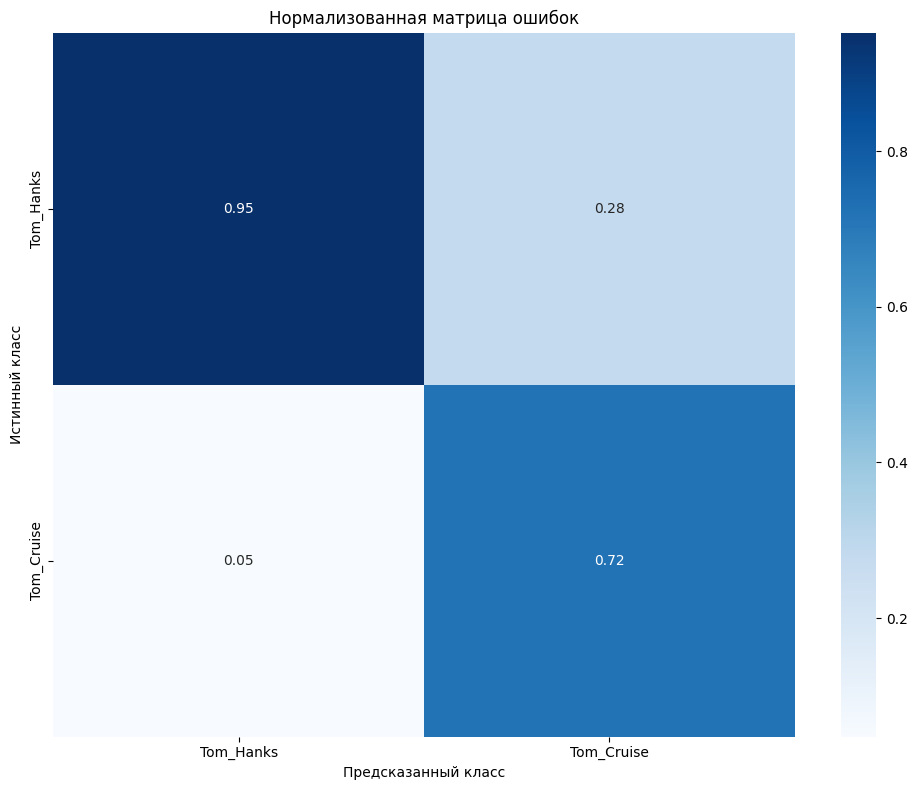

In [ ]:
plot_confusion_matrix(efficientnet_b0_metrics_15N["confusion_matrix"], idx_to_class.values())

In [ ]:
benchmarks["efficientnet_b0_15N"] = efficientnet_b0_metrics_15N

<Figure size 1400x800 with 0 Axes>

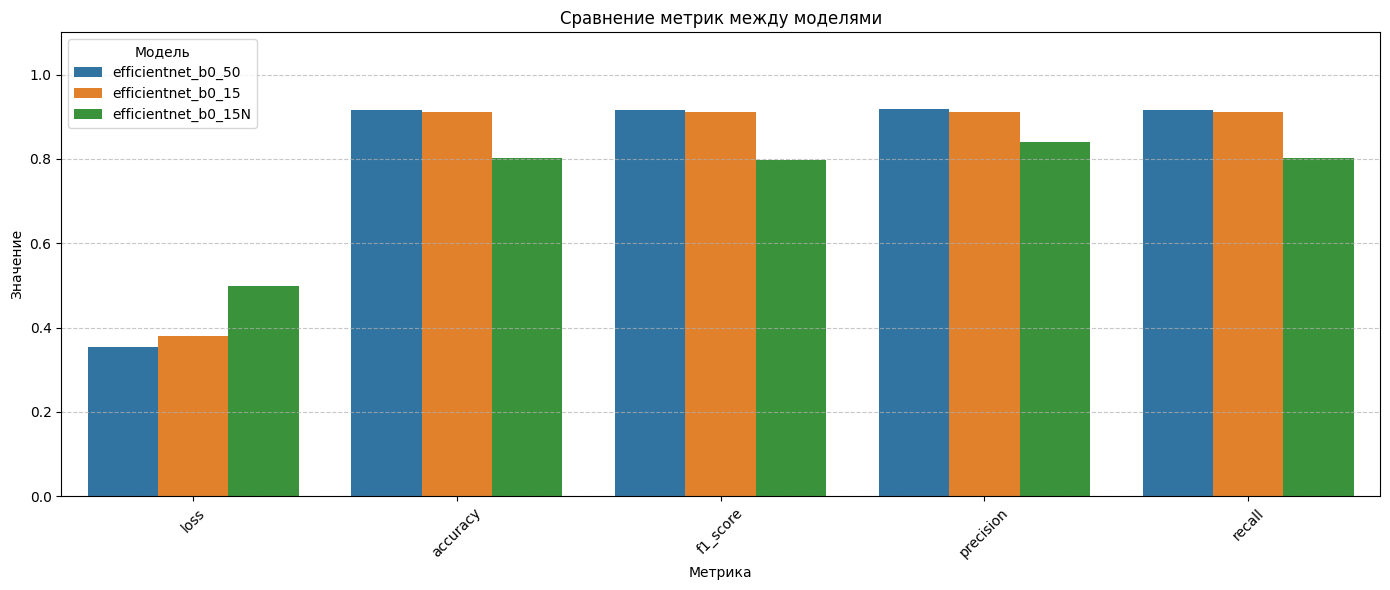

In [ ]:
comparison_df = compare_benchmarks(benchmarks)

Как и ожидалось, метрики стали чуть ниже, однако показатели остаются высоки!

*>= 0,8 по каждому показателю*

### Новая модель (B7)

Заметим, что EfficentNet B0 занимает всего десятки мегабайт при обучении, а также совем не требовательна к размеру фотографий (224x224px), попробуем взять старшую модель из этого же семейства (B7, с 64M параметров), и посмотреть на тех же бенчмарках.

In [ ]:
# Загрузка названий классов из JSON
with open("/content/drive/MyDrive/classification/class_to_idx.json", "r")  as f:
  class_to_idx = json.load(f)

In [ ]:
# Создание обратного словаря idx_to_class
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [ ]:
directory_path = '/content/dataset'

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Директория {directory_path} успешно удалена.")
else:
    print(f"Директория {directory_path} не существует.")

Директория /content/dataset успешно удалена.


In [ ]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(
    train_dir='/content/dataset/classification_dataset/train',
    test_dir='/content/dataset/classification_dataset/test',
    hyperparams=hyperparams,
    target_size=50,
    image_size=600 # Модель B7 ожидает фотографии большего качества на вход
)

In [ ]:
# Загрузка модели EfficientNet
model = efficientnet_b7(EfficientNet_B7_Weights.DEFAULT)

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Замена финального классификатора
num_features = model.classifier[1].in_features
num_classes = len(class_to_idx)  # Количество классов из JSON
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Многоклассовая классификация
    # На выходе оставляем сырые логиты, так как nn.CrossEntropyLoss() их ожидает на вход
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)

In [ ]:
# @title Текущее потребление памяти
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Максимальный объем памяти = {max_memory} ГБ.")
print(f"{start_gpu_memory} ГБ памяти зарезервировано.")

GPU = Tesla T4. Максимальный объем памяти = 14.741 ГБ.
0.756 ГБ памяти зарезервировано.


In [ ]:
start_time = time.time()

efficientnet_b7_history_50, efficientnet_b7_50 = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)

train_runtime = time.time() - start_time

Epoch 1/10
Train Loss: 0.6674, Train Acc: 0.6700
Val Loss: 0.6227, Val Acc: 0.9460, Val F1: 0.9459, Precision: 0.9505, Recall: 0.9460
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.5965, Train Acc: 0.8900
Val Loss: 0.5650, Val Acc: 0.9890, Val F1: 0.9890, Precision: 0.9892, Recall: 0.9890
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.5320, Train Acc: 0.9300
Val Loss: 0.5253, Val Acc: 0.9860, Val F1: 0.9860, Precision: 0.9861, Recall: 0.9860
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.4462, Train Acc: 0.9600
Val Loss: 0.4879, Val Acc: 0.9860, Val F1: 0.9860, Precision: 0.9862, Recall: 0.9860
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.3642, Train Acc: 0.9900
Val Loss: 0.4511, Val Acc: 0.9880, Val F1: 0.9880, Precision: 0.9882, Recall: 0.9880
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [ ]:
# @title Потребление памяти после обучения
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_training = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
training_percentage = round(used_memory_for_training / max_memory * 100, 3)

# Выводим статистику
print(f"{train_runtime} секунд затрачено на обучение.")
print(
    f"{round(train_runtime/60, 2)} минут затрачено на обучение."
)
print(f"Пиковый объем зарезервированной памяти = {used_memory} ГБ.")
print(f"Пиковый объем зарезервированной памяти для обучения = {used_memory_for_training} ГБ.")
print(f"Пиковый объем зарезервированной памяти в % от максимальной памяти = {used_percentage} %.")
print(f"Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = {training_percentage} %.")

864.7517783641815 секунд затрачено на обучение.
14.41 минут затрачено на обучение.
Пиковый объем зарезервированной памяти = 2.852 ГБ.
Пиковый объем зарезервированной памяти для обучения = 2.096 ГБ.
Пиковый объем зарезервированной памяти в % от максимальной памяти = 19.347 %.
Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = 14.219 %.


In [ ]:
efficientnet_b7_metrics_50 = evaluate_model(efficientnet_b7_50, test_loader, criterion, device)

In [ ]:
efficientnet_b7_metrics_50["confusion_matrix"]

array([[499,   1],
       [ 15, 485]])

In [ ]:
efficientnet_b7_metrics_50["class_report"]

{'0': {'precision': 0.9708171206225681,
  'recall': 0.998,
  'f1-score': 0.9842209072978304,
  'support': 500.0},
 '1': {'precision': 0.9979423868312757,
  'recall': 0.97,
  'f1-score': 0.9837728194726166,
  'support': 500.0},
 'accuracy': 0.984,
 'macro avg': {'precision': 0.9843797537269219,
  'recall': 0.984,
  'f1-score': 0.9839968633852235,
  'support': 1000.0},
 'weighted avg': {'precision': 0.9843797537269219,
  'recall': 0.984,
  'f1-score': 0.9839968633852236,
  'support': 1000.0}}

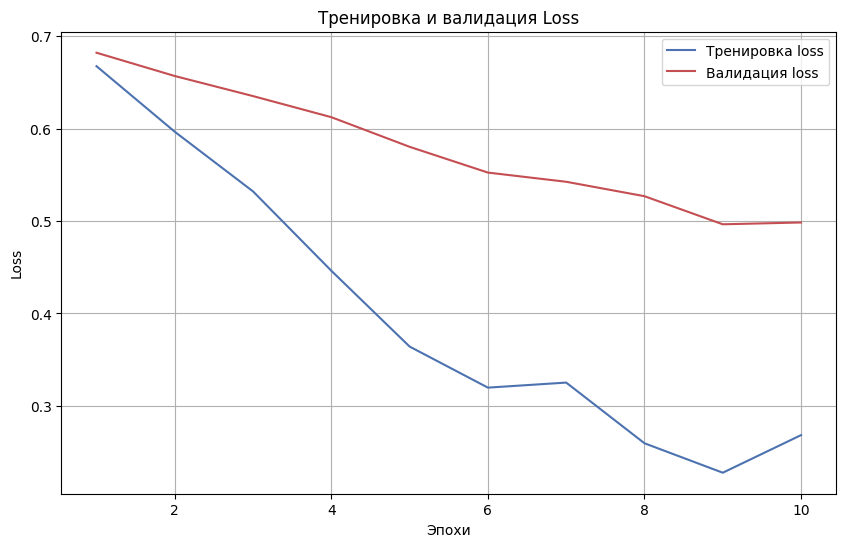

In [ ]:
plot_training_history(efficientnet_b7_history_50['train_loss'], efficientnet_b0_history_15N['val_loss'], 'loss')

In [ ]:
benchmarks["efficientnet_b7_50"] = efficientnet_b7_metrics_50

<Figure size 1400x800 with 0 Axes>

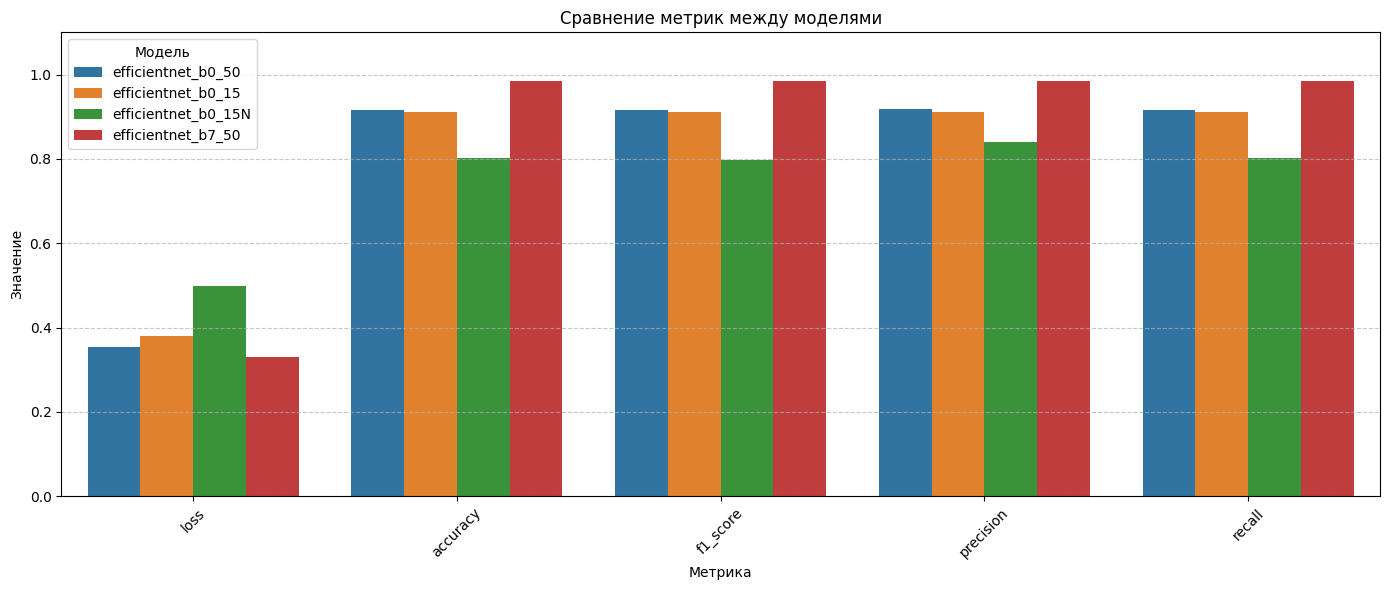

In [ ]:
comparison_df = compare_benchmarks(benchmarks)

Поразительные метрики! Но также заметим, что памяти было занято более чем в 10 раз, попробуем еще на неизвестных модели классов и их малым кол-вом, все те же Tom Hanks и Tom Cruise

In [ ]:
# Загрузка новых названий классов из JSON
with open("/content/drive/MyDrive/classification/class_to_idx_celebrity.json", "r")  as f:
  class_to_idx = json.load(f)

In [ ]:
directory_path = '/content/dataset'

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Директория {directory_path} успешно удалена.")
else:
    print(f"Директория {directory_path} не существует.")

Директория /content/dataset успешно удалена.


In [ ]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset_selebrity.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(
    train_dir='/content/dataset/classification_dataset/train',
    test_dir='/content/dataset/classification_dataset/test',
    hyperparams=hyperparams,
    target_size=50,
    image_size=600
)

In [ ]:
# Загрузка модели EfficientNet
model = efficientnet_b7(EfficientNet_B7_Weights.DEFAULT)

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Замена финального классификатора
num_features = model.classifier[1].in_features
num_classes = len(class_to_idx)  # Количество классов из JSON
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Многоклассовая классификация
    # На выходе оставляем сырые логиты, так как nn.CrossEntropyLoss() их ожидает на вход
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)

In [ ]:
efficientnet_b7_history_15N, efficientnet_b7_15N = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)

Epoch 1/10
Train Loss: 0.6829, Train Acc: 0.5600
Val Loss: 0.6875, Val Acc: 0.6328, Val F1: 0.6321, Precision: 0.6324, Recall: 0.6328
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.6261, Train Acc: 0.8400
Val Loss: 0.6804, Val Acc: 0.7401, Val F1: 0.7402, Precision: 0.7419, Recall: 0.7401
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.5715, Train Acc: 0.9300
Val Loss: 0.6747, Val Acc: 0.7514, Val F1: 0.7506, Precision: 0.7594, Recall: 0.7514
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.4967, Train Acc: 0.9900
Val Loss: 0.6670, Val Acc: 0.7966, Val F1: 0.7942, Precision: 0.8053, Recall: 0.7966
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.4460, Train Acc: 0.9700
Val Loss: 0.6556, Val Acc: 0.7401, Val F1: 0.7327, Precision: 0.7600, Recall: 0.7401
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [ ]:
efficientnet_b7_metrics_15N = evaluate_model(efficientnet_b7_15N, test_loader, criterion, device)

In [ ]:
benchmarks["efficientnet_b7_15N"] = efficientnet_b7_metrics_15N

<Figure size 1400x800 with 0 Axes>

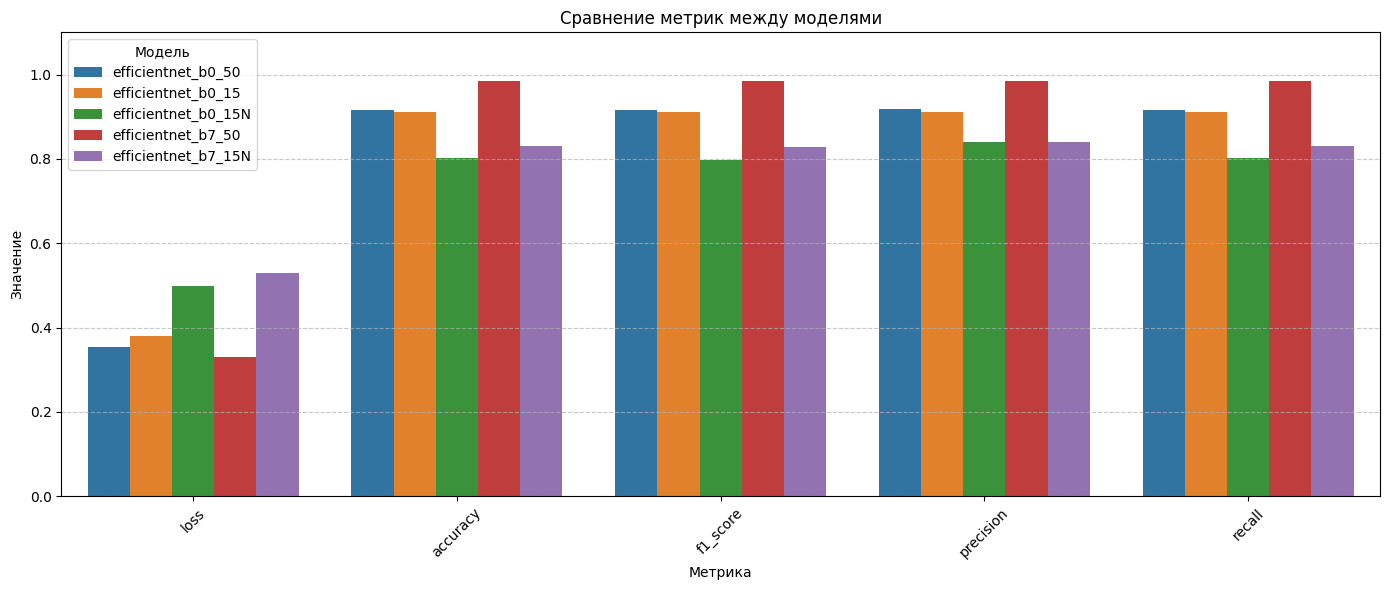

In [ ]:
comparison_df = compare_benchmarks(benchmarks)

Метрики на уровене, что и у младшей модели, заметим, что лосс на валидации не упал до плато, поэтому попробуем обучится еще на 10 эпохах.

In [ ]:
efficientnet_b7_history_15N, efficientnet_b7_15N = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)

Epoch 1/10
Train Loss: 0.2319, Train Acc: 0.9600
Val Loss: 0.4998, Val Acc: 0.8418, Val F1: 0.8403, Precision: 0.8497, Recall: 0.8418
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.2383, Train Acc: 0.9600
Val Loss: 0.4746, Val Acc: 0.8588, Val F1: 0.8572, Precision: 0.8685, Recall: 0.8588
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.1716, Train Acc: 0.9900
Val Loss: 0.4516, Val Acc: 0.8644, Val F1: 0.8628, Precision: 0.8759, Recall: 0.8644
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.1616, Train Acc: 0.9600
Val Loss: 0.4296, Val Acc: 0.8701, Val F1: 0.8687, Precision: 0.8803, Recall: 0.8701
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.1318, Train Acc: 1.0000
Val Loss: 0.4129, Val Acc: 0.8701, Val F1: 0.8687, Precision: 0.8803, Recall: 0.8701
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [ ]:
benchmarks["efficientnet_b7_15N"] = efficientnet_b7_metrics_15N

<Figure size 1400x800 with 0 Axes>

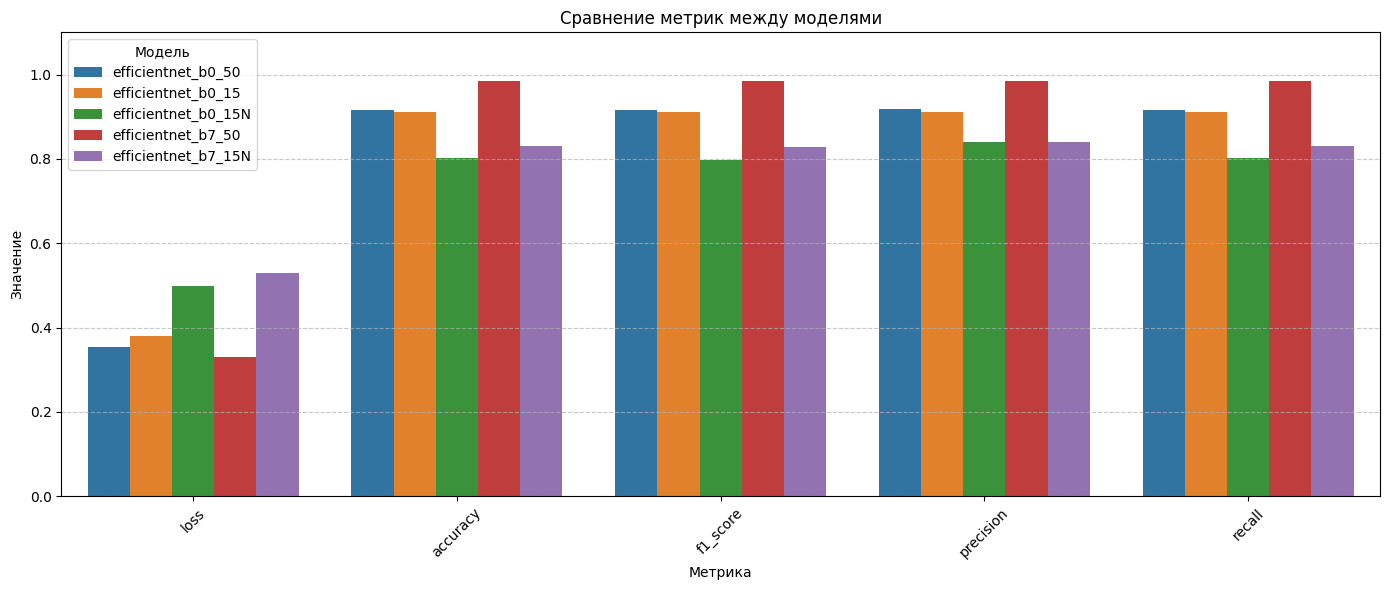

In [ ]:
comparison_df = compare_benchmarks(benchmarks)

Метрики также идентичны, что означает, что 15 изображений не хватает для полноценного обучения большой модели, и она уже взяла максимум признаков из них

# YOLO11

Ultralytics YOLO11 - Новейшая версия известной модели для разных задач - обнаружения объектов, сегментации изображений, классификации и т.д.

Мы будем использовать версию для классификации, которая представлена 5 моделями:
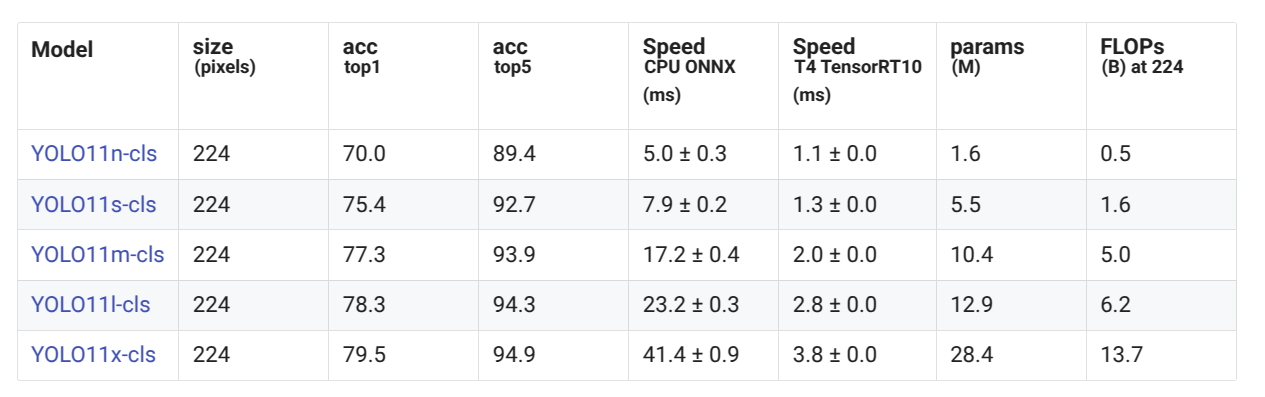

In [ ]:
%%capture
!pip install --upgrade ultralytics

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import json
import shutil
import time

## Предобработка данных

*train* метод в ultralytics автоматически применяет нужные трансформации к данным, поэтому остается лишь загрузить датасет. Начнем с 50 фотографии по каждому известному классу *(YOLO V11 также была предобучена на ImageNet)*

In [ ]:
directory_path = '/content/dataset'

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Директория {directory_path} успешно удалена.")
else:
    print(f"Директория {directory_path} не существует.")

Директория /content/dataset успешно удалена.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Загрузка гиперпараметров из JSON (создайте папку classification, если её еще нет в корне диска Google Drive)
with open('/content/drive/MyDrive/classification/hyperparams.json', "r") as f:
  hyperparams = json.load(f)

In [ ]:
# Загрузка названий классов из JSON
with open("/content/drive/MyDrive/classification/class_to_idx.json", "r")  as f:
  class_to_idx = json.load(f)

In [ ]:
# Создание обратного словаря idx_to_class
idx_to_class = {v: k for k, v in class_to_idx.items()}


**Структура** c*lassification_dataset.zip*: (внутри папка с таким же названием)

```
classification_dataset/
├── train/
│   ├── class_name1/
│   └── class_name2/
│   └── ...

└── test/
    ├── class_name1/
    └── class_name2/
    └── ...
```



In [ ]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

## Загрузка модели и обучение

Начнем с самой маленькой модели из семейства *(YOLO11n-cls)* всего на 1,6M параметров

Так как она очень маленькая и обучаться будет довольно быстро, попробуем обновлять все веса модели, без заморозки. Также узнаем, будет ли переобучаться YOLO если не замораживать остальные слои

In [ ]:
# для тестирования
os.rename("/content/dataset/classification_dataset/test", "/content/dataset/classification_dataset/val")

In [ ]:
# @title Текущее потребление памяти
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Максимальный объем памяти = {max_memory} ГБ.")
print(f"{start_gpu_memory} ГБ памяти зарезервировано.")

GPU = Tesla T4. Максимальный объем памяти = 14.741 ГБ.
2.908 ГБ памяти зарезервировано.


In [ ]:
from ultralytics import YOLO

model = YOLO('yolo11n-cls.pt')
start_time = time.time()
results = model.train(data='/content/dataset/classification_dataset', epochs=10, imgsz=224, name='yolo11n_cls_50')
train_runtime = time.time() - start_time

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=/content/dataset/classification_dataset, epochs=10, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11n_cls_502, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

AMP: checks passed ✅


train: Scanning /content/dataset/classification_dataset/train... 112 images, 0 corrupt: 100%|██████████| 112/112 [00:00<00:00, 4359.42it/s]

train: New cache created: /content/dataset/classification_dataset/train.cache



val: Scanning /content/dataset/classification_dataset/val... 999 images, 1 corrupt: 100%|██████████| 1000/1000 [00:00<00:00, 1864.79it/s]

val: WARNING ⚠️ /content/dataset/classification_dataset/val/dog/1546.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/dataset/classification_dataset/val/dog/1575.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/dataset/classification_dataset/val/dog/1721.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/dataset/classification_dataset/val/dog/1767.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /content/dataset/classification_dataset/val/dog/1866.jpg: ignoring corrupt image/label: Invalid image format GIF. Supported formats are:
images: {'tif', 'pfm', 'jpeg', 'heic', 'bmp', 'jpg', 'tiff', 'dng', 'png', 'webp', 'mpo'}
videos: {'mkv', 'wmv', 'mov', 'mpeg', 'avi', 'gif', 'mpg', 'mp4', 'webm', 'asf', 'ts', 'm4v'}
val: WARNING ⚠️ /content/dataset/classification_dataset/val/dog/1975.jpg: corrupt JPEG restored and saved
val: New cache created: /content/dataset/classification_dataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/yolo11n_cls_502
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.605          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.886          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.934          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.935          1



10 epochs completed in 0.021 hours.
Optimizer stripped from runs/classify/yolo11n_cls_502/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/yolo11n_cls_502/weights/best.pt, 3.2MB

Validating runs/classify/yolo11n_cls_502/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
train: /content/dataset/classification_dataset/train... found 112 images in 2 classes ✅ 
val: /content/dataset/classification_dataset/val... found 1000 images in 2 classes ✅ 
test: None...


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

                   all       0.94          1
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/yolo11n_cls_502


In [ ]:
# @title Потребление памяти после обучения
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_training = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
training_percentage = round(used_memory_for_training / max_memory * 100, 3)

# Выводим статистику
print(f"{train_runtime} секунд затрачено на обучение.")
print(
    f"{round(train_runtime/60, 2)} минут затрачено на обучение."
)
print(f"Пиковый объем зарезервированной памяти = {used_memory} ГБ.")
print(f"Пиковый объем зарезервированной памяти для обучения = {used_memory_for_training} ГБ.")
print(f"Пиковый объем зарезервированной памяти в % от максимальной памяти = {used_percentage} %.")
print(f"Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = {training_percentage} %.")

83.13206744194031 секунд затрачено на обучение.
1.39 минут затрачено на обучение.
Пиковый объем зарезервированной памяти = 3.041 ГБ.
Пиковый объем зарезервированной памяти для обучения = 0.133 ГБ.
Пиковый объем зарезервированной памяти в % от максимальной памяти = 20.63 %.
Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = 0.902 %.


т.к ultralytics classify class не поддерживает подсчет метрик f1, recall, precision изначально, а использовать функции без test_loader невозможно, то сделаем сравнение с помощью сгенерированной при валидации на тестовом датасете Confusion Matrix:

In [ ]:
from IPython.display import Image

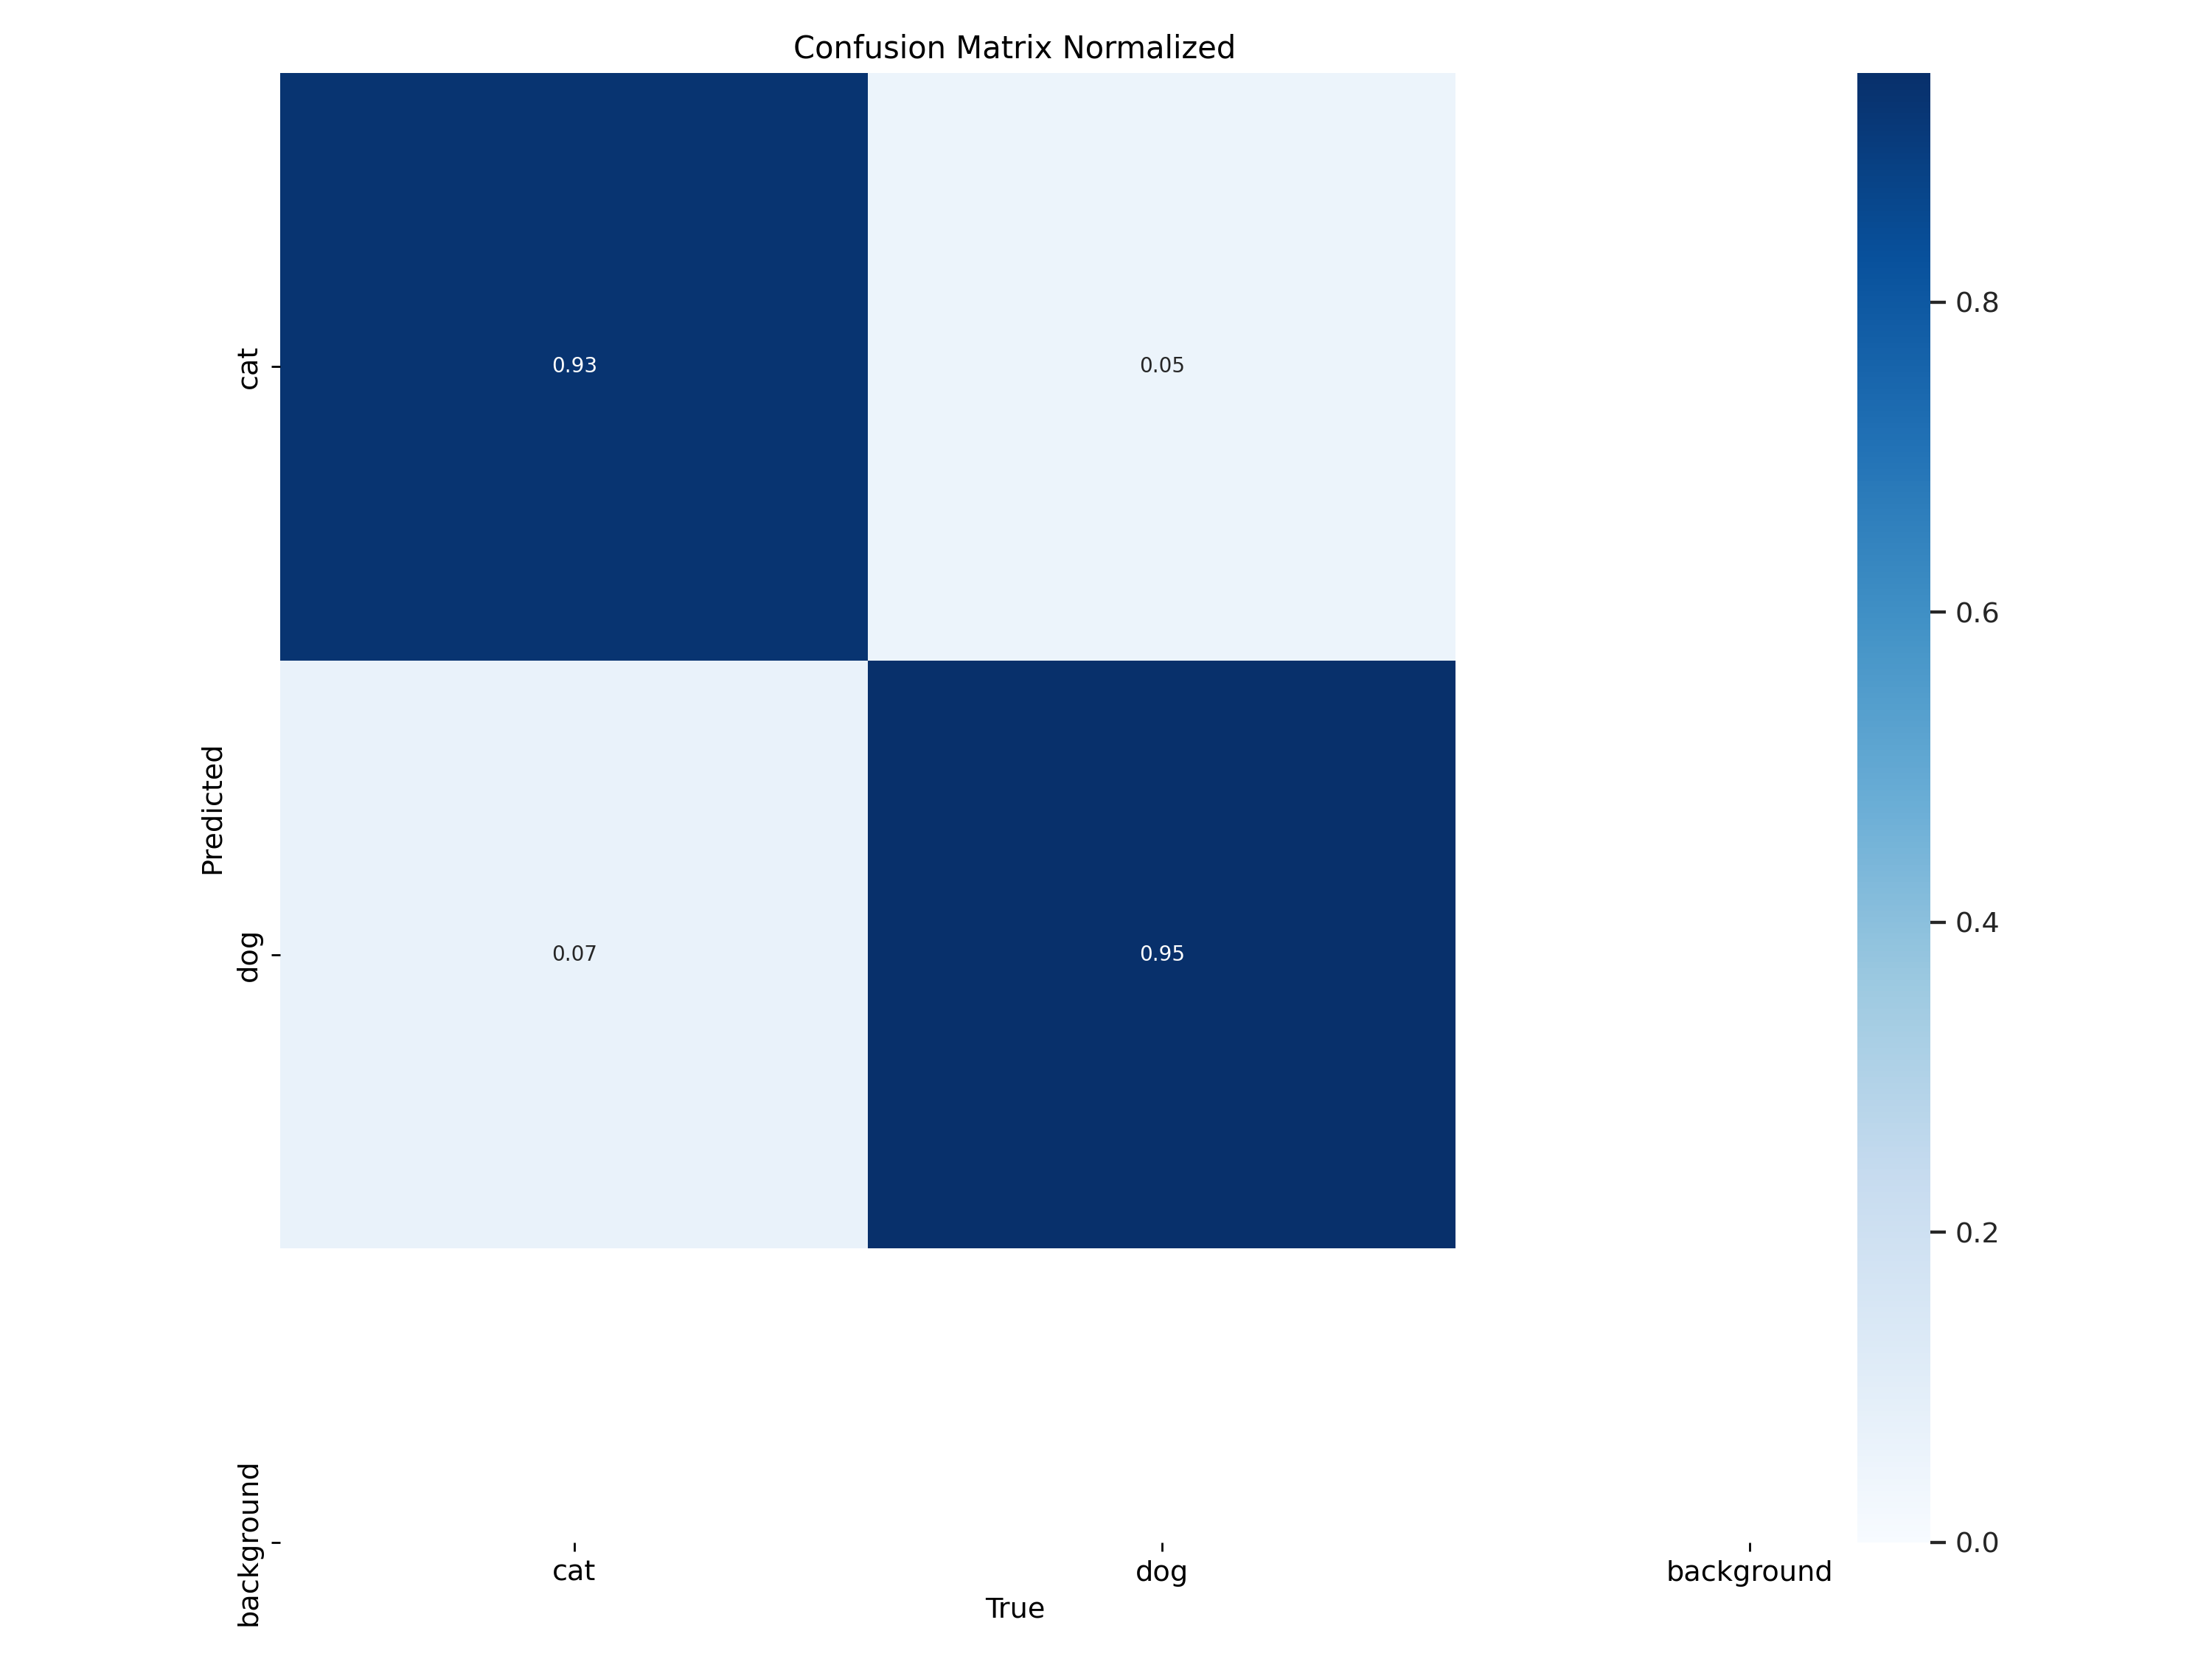

In [ ]:
Image("/content/runs/classify/yolo11n_cls_50/confusion_matrix_normalized.png", width=800)

А вот такой результат был у EfficentNet_B0_50:


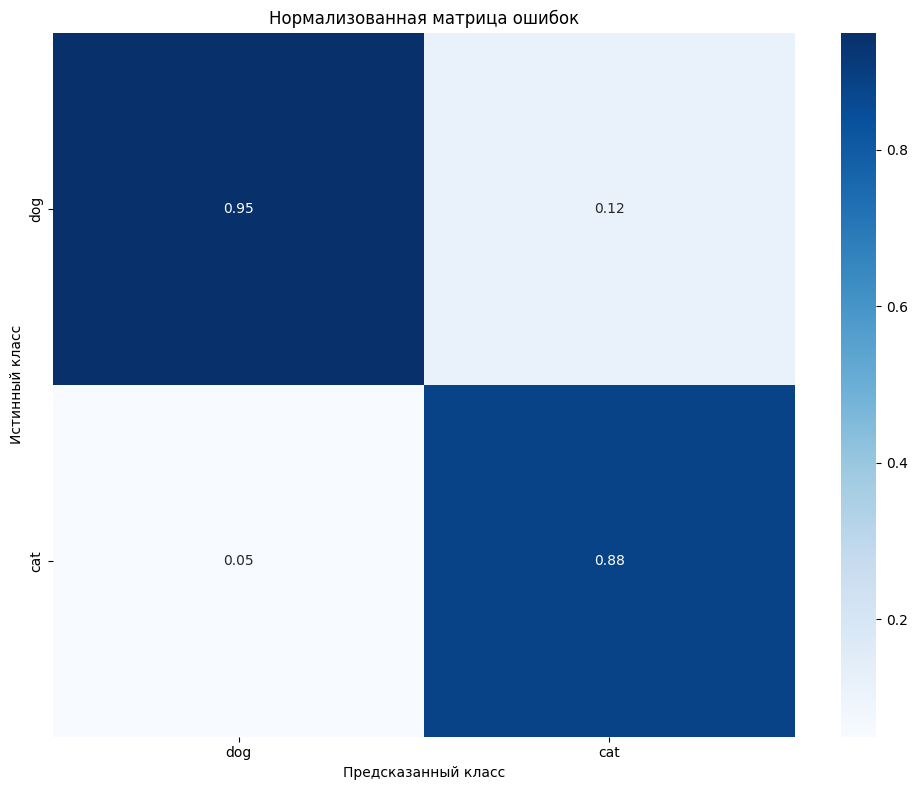

In [ ]:
plot_confusion_matrix(efficientnet_b0_metrics_50["confusion_matrix"], idx_to_class.values())

т.е YOLO с размороженными слоями ( однако обучение не медлительнее) выигрывает у EfficentNet в случае если датасет довольно обьемный и классы заранее известны

попробуем вернутся к реальному кейсу с неизвестными классами и малой выборкой

In [ ]:
# Загрузка новых названий классов из JSON
with open("/content/drive/MyDrive/classification/class_to_idx_celebrity.json", "r")  as f:
  class_to_idx = json.load(f)

In [ ]:
# Создание обратного словаря idx_to_class
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [ ]:
directory_path = '/content/dataset'

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Директория {directory_path} успешно удалена.")
else:
    print(f"Директория {directory_path} не существует.")

Директория /content/dataset успешно удалена.


In [ ]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset_selebrity.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
# для тестирования
os.rename("/content/dataset/classification_dataset/test", "/content/dataset/classification_dataset/val")

In [ ]:
# @title Текущее потребление памяти
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Максимальный объем памяти = {max_memory} ГБ.")
print(f"{start_gpu_memory} ГБ памяти зарезервировано.")

GPU = Tesla T4. Максимальный объем памяти = 14.741 ГБ.
3.041 ГБ памяти зарезервировано.


In [ ]:
model = YOLO('yolo11n-cls.pt')
start_time = time.time()
results = model.train(data='/content/dataset/classification_dataset', epochs=10, imgsz=224, name='yolo11n_cls_15N')
train_runtime = time.time() - start_time

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=/content/dataset/classification_dataset, epochs=10, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11n_cls_15N2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

AMP: checks passed ✅


train: Scanning /content/dataset/classification_dataset/train... 30 images, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 3278.93it/s]

train: New cache created: /content/dataset/classification_dataset/train.cache



val: Scanning /content/dataset/classification_dataset/val... 177 images, 0 corrupt: 100%|██████████| 177/177 [00:00<00:00, 2529.75it/s]

val: New cache created: /content/dataset/classification_dataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/yolo11n_cls_15N2
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.514          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.503          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.554          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.605          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.684          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.729          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.819          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.814          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.825          1



10 epochs completed in 0.004 hours.
Optimizer stripped from runs/classify/yolo11n_cls_15N2/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/yolo11n_cls_15N2/weights/best.pt, 3.2MB

Validating runs/classify/yolo11n_cls_15N2/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
train: /content/dataset/classification_dataset/train... found 30 images in 2 classes ✅ 
val: /content/dataset/classification_dataset/val... found 177 images in 2 classes ✅ 
test: None...


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

                   all      0.825          1
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/yolo11n_cls_15N2


In [ ]:
# @title Потребление памяти после обучения
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_training = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
training_percentage = round(used_memory_for_training / max_memory * 100, 3)

# Выводим статистику
print(f"{train_runtime} секунд затрачено на обучение.")
print(
    f"{round(train_runtime/60, 2)} минут затрачено на обучение."
)
print(f"Пиковый объем зарезервированной памяти = {used_memory} ГБ.")
print(f"Пиковый объем зарезервированной памяти для обучения = {used_memory_for_training} ГБ.")
print(f"Пиковый объем зарезервированной памяти в % от максимальной памяти = {used_percentage} %.")
print(f"Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = {training_percentage} %.")

23.424061059951782 секунд затрачено на обучение.
0.39 минут затрачено на обучение.
Пиковый объем зарезервированной памяти = 3.041 ГБ.
Пиковый объем зарезервированной памяти для обучения = 0.0 ГБ.
Пиковый объем зарезервированной памяти в % от максимальной памяти = 20.63 %.
Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = 0.0 %.


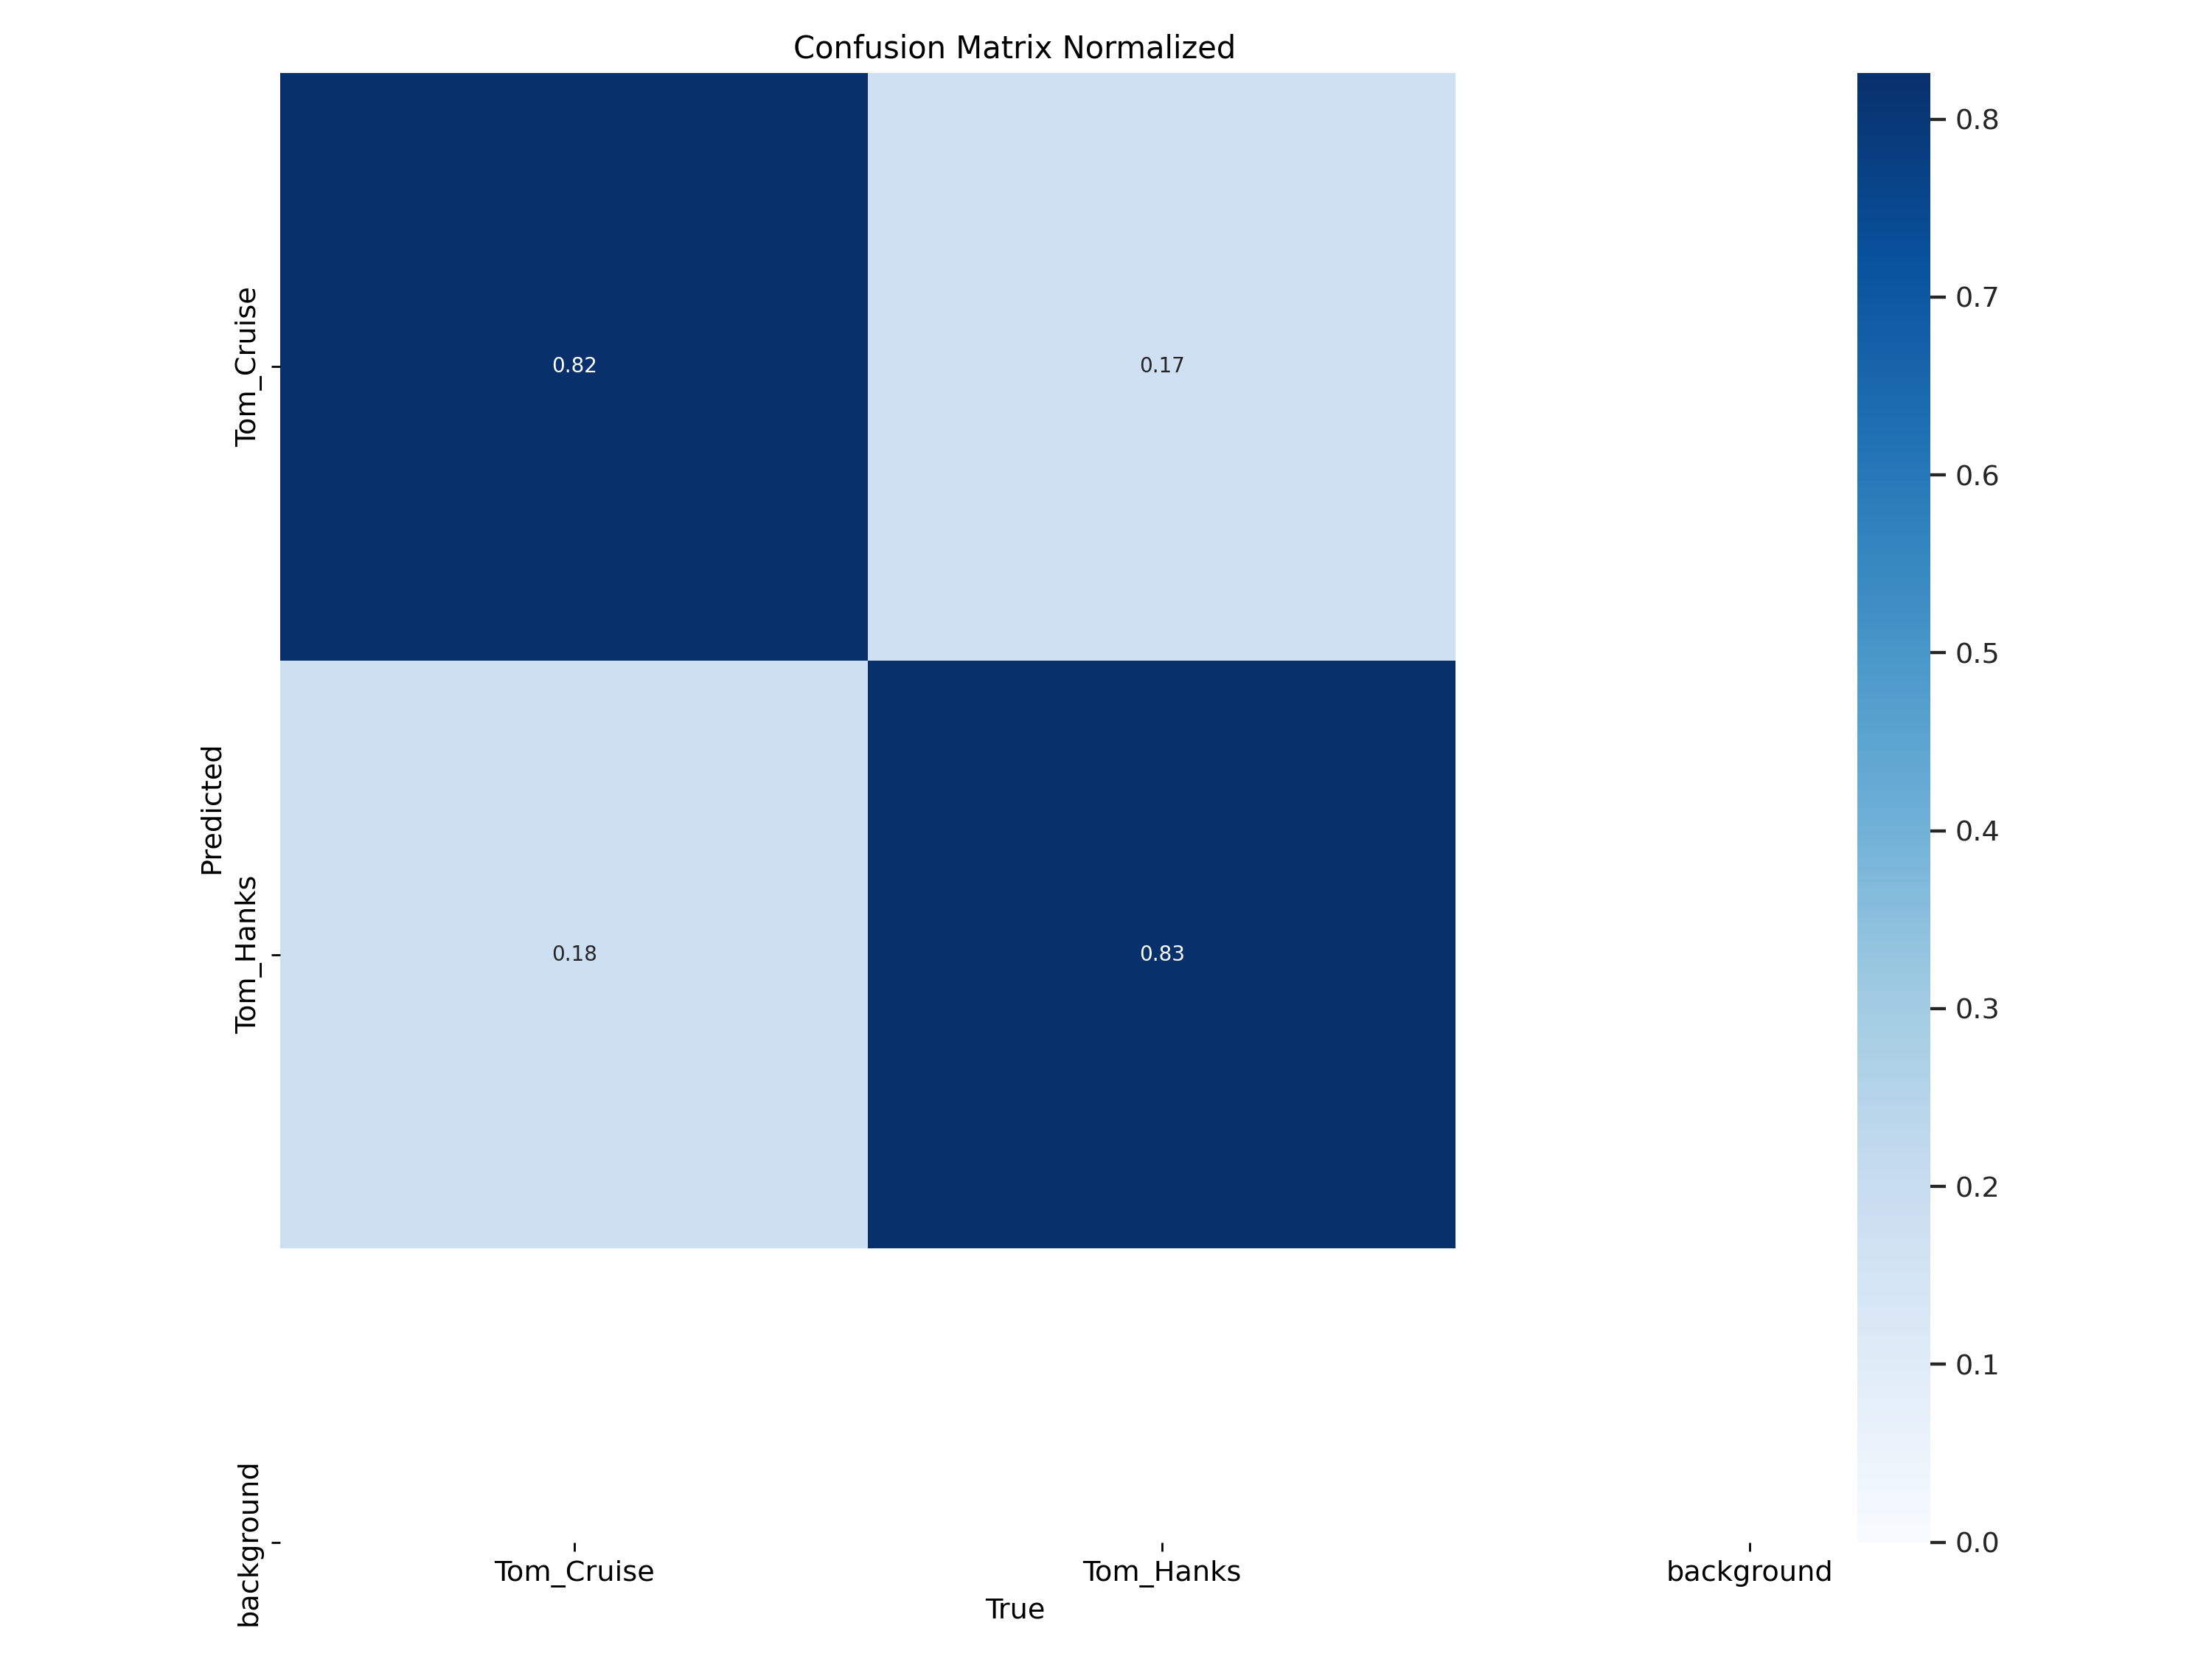

In [ ]:
Image("/content/runs/classify/yolo11n_cls_15N/confusion_matrix_normalized.png", width=800)

Сравниваем с предыдущей моделью: (B0)

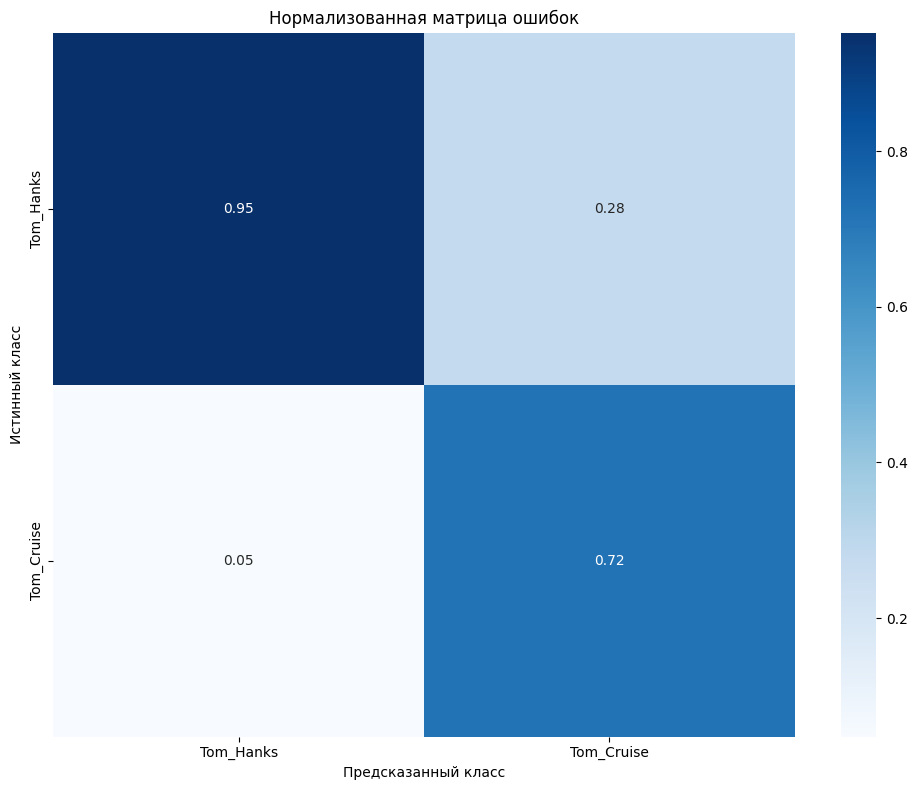

In [ ]:
plot_confusion_matrix(efficientnet_b0_metrics_15N["confusion_matrix"], idx_to_class.values())

Результаты на одном уровне, попробуем заморозить слои:

In [ ]:
model = YOLO('yolo11n-cls.pt')

In [ ]:
model

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

Нам нужно заморозить все блоки, по 9, 10 остается размороженным, метод трейна же сам преобразует кол-ва выходов на кол-во наших классов

In [ ]:
# @title Текущее потребление памяти
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Максимальный объем памяти = {max_memory} ГБ.")
print(f"{start_gpu_memory} ГБ памяти зарезервировано.")

GPU = Tesla T4. Максимальный объем памяти = 14.741 ГБ.
3.041 ГБ памяти зарезервировано.


In [ ]:
start_time = time.time()
results = model.train(data='/content/dataset/classification_dataset', epochs=10, imgsz=224, freeze=9, name="yolo11n_cls_15N_f9")
train_runtime = time.time() - start_time

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=/content/dataset/classification_dataset, epochs=10, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11n_cls_15N_f92, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=9, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

AMP: checks passed ✅


train: Scanning /content/dataset/classification_dataset/train... 30 images, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
val: Scanning /content/dataset/classification_dataset/val... 177 images, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/yolo11n_cls_15N_f92
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.514          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.503          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.542          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.576          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.627          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.661          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.723          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all       0.74          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all       0.74          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.751          1



10 epochs completed in 0.004 hours.
Optimizer stripped from runs/classify/yolo11n_cls_15N_f92/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/yolo11n_cls_15N_f92/weights/best.pt, 3.2MB

Validating runs/classify/yolo11n_cls_15N_f92/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
train: /content/dataset/classification_dataset/train... found 30 images in 2 classes ✅ 
val: /content/dataset/classification_dataset/val... found 177 images in 2 classes ✅ 
test: None...


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

                   all      0.746          1
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/yolo11n_cls_15N_f92


In [ ]:
# @title Потребление памяти после обучения
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_training = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
training_percentage = round(used_memory_for_training / max_memory * 100, 3)

# Выводим статистику
print(f"{train_runtime} секунд затрачено на обучение.")
print(
    f"{round(train_runtime/60, 2)} минут затрачено на обучение."
)
print(f"Пиковый объем зарезервированной памяти = {used_memory} ГБ.")
print(f"Пиковый объем зарезервированной памяти для обучения = {used_memory_for_training} ГБ.")
print(f"Пиковый объем зарезервированной памяти в % от максимальной памяти = {used_percentage} %.")
print(f"Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = {training_percentage} %.")

23.508325338363647 секунд затрачено на обучение.
0.39 минут затрачено на обучение.
Пиковый объем зарезервированной памяти = 3.041 ГБ.
Пиковый объем зарезервированной памяти для обучения = 0.0 ГБ.
Пиковый объем зарезервированной памяти в % от максимальной памяти = 20.63 %.
Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = 0.0 %.


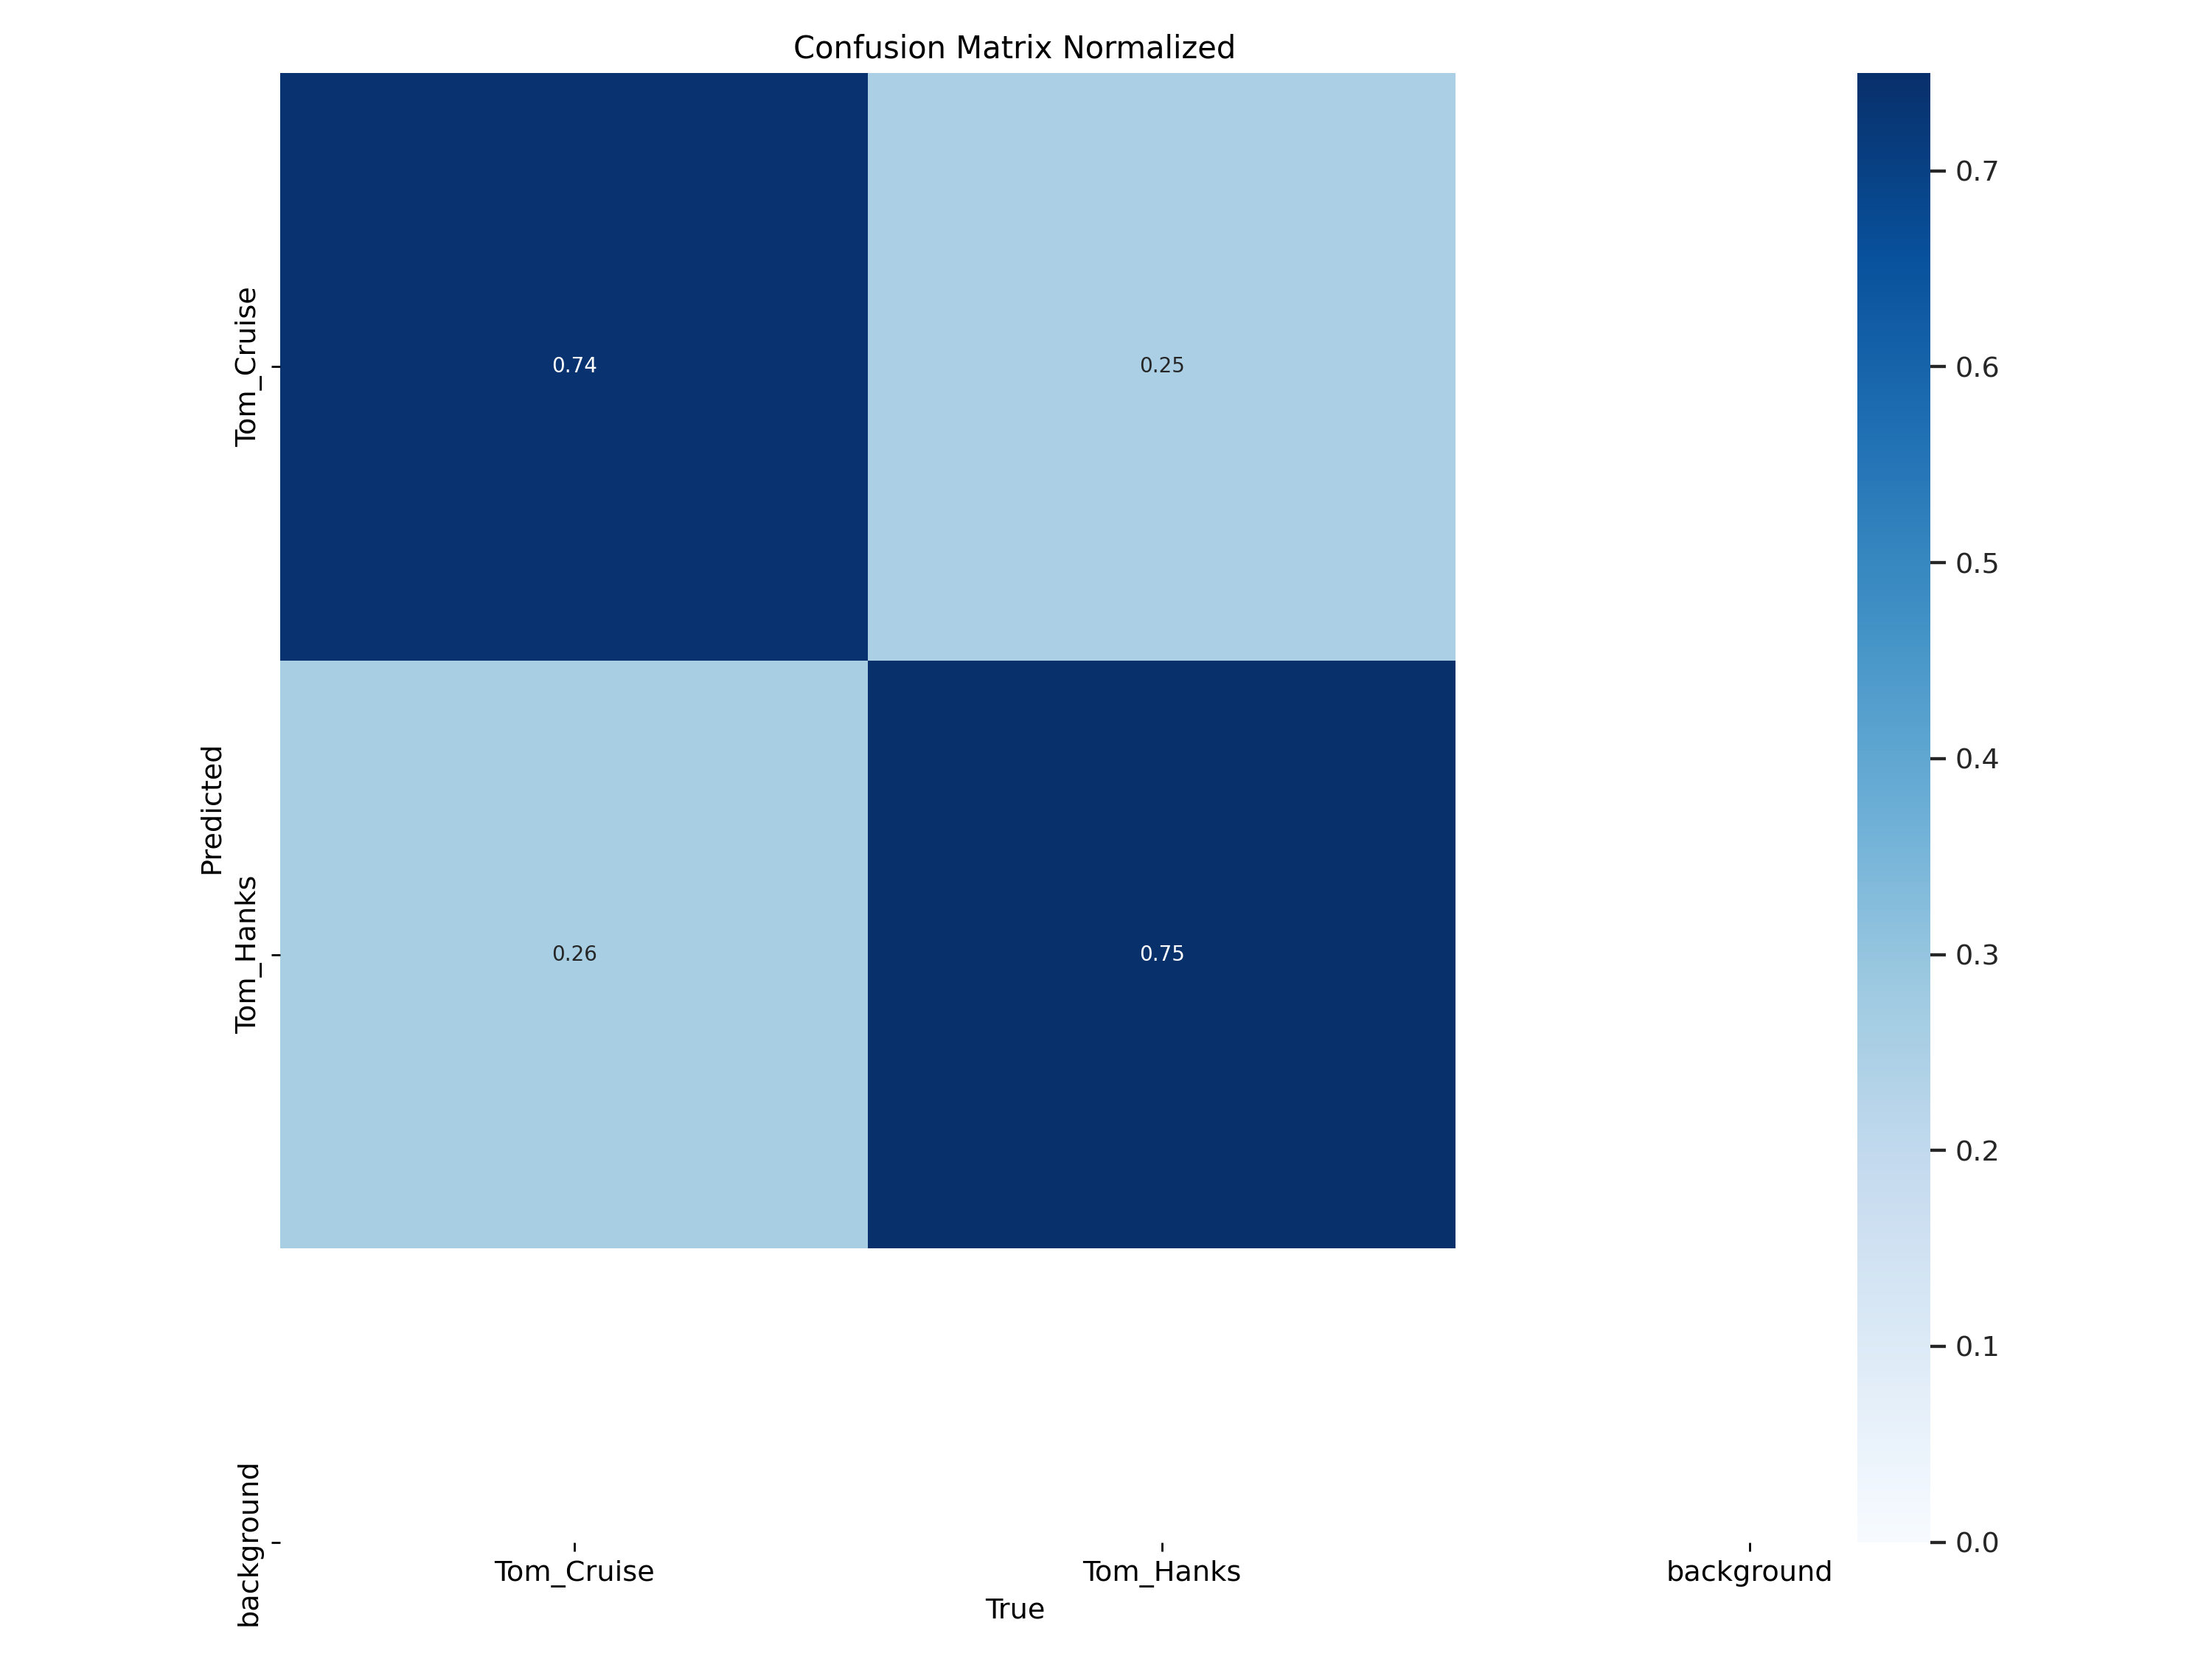

In [ ]:
Image("/content/runs/classify/yolo11n_cls_15N_f9/confusion_matrix_normalized.png", width=800)

Реузльтаты стали хуже, возьмем следующую модель из семейства - `yolo11s-cls`

In [ ]:
model = YOLO('yolo11s-cls.pt')

In [ ]:
model

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

Архитектурно схоже, пока попробуем без Transfer learning:

In [ ]:
# @title Текущее потребление памяти
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Максимальный объем памяти = {max_memory} ГБ.")
print(f"{start_gpu_memory} ГБ памяти зарезервировано.")

GPU = Tesla T4. Максимальный объем памяти = 14.741 ГБ.
3.041 ГБ памяти зарезервировано.


In [ ]:
start_time = time.time()
results = model.train(data='/content/dataset/classification_dataset', epochs=10, imgsz=224, name="yolo11s_cls_15N")
train_runtime = time.time() - start_time

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolo11s-cls.pt, data=/content/dataset/classification_dataset, epochs=10, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11s_cls_15N2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

AMP: checks passed ✅


train: Scanning /content/dataset/classification_dataset/train... 30 images, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
val: Scanning /content/dataset/classification_dataset/val... 177 images, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/yolo11s_cls_15N2
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.328          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.345          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.384          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.446          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.576          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.701          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.768          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.814          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.831          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.847          1



10 epochs completed in 0.005 hours.
Optimizer stripped from runs/classify/yolo11s_cls_15N2/weights/last.pt, 11.0MB
Optimizer stripped from runs/classify/yolo11s_cls_15N2/weights/best.pt, 11.0MB

Validating runs/classify/yolo11s_cls_15N2/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-cls summary (fused): 47 layers, 5,436,690 parameters, 0 gradients, 12.0 GFLOPs
train: /content/dataset/classification_dataset/train... found 30 images in 2 classes ✅ 
val: /content/dataset/classification_dataset/val... found 177 images in 2 classes ✅ 
test: None...


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

                   all      0.842          1
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/yolo11s_cls_15N2


In [ ]:
# @title Потребление памяти после обучения
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_training = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
training_percentage = round(used_memory_for_training / max_memory * 100, 3)

# Выводим статистику
print(f"{train_runtime} секунд затрачено на обучение.")
print(
    f"{round(train_runtime/60, 2)} минут затрачено на обучение."
)
print(f"Пиковый объем зарезервированной памяти = {used_memory} ГБ.")
print(f"Пиковый объем зарезервированной памяти для обучения = {used_memory_for_training} ГБ.")
print(f"Пиковый объем зарезервированной памяти в % от максимальной памяти = {used_percentage} %.")
print(f"Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = {training_percentage} %.")

25.418360233306885 секунд затрачено на обучение.
0.42 минут затрачено на обучение.
Пиковый объем зарезервированной памяти = 3.041 ГБ.
Пиковый объем зарезервированной памяти для обучения = 0.0 ГБ.
Пиковый объем зарезервированной памяти в % от максимальной памяти = 20.63 %.
Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = 0.0 %.


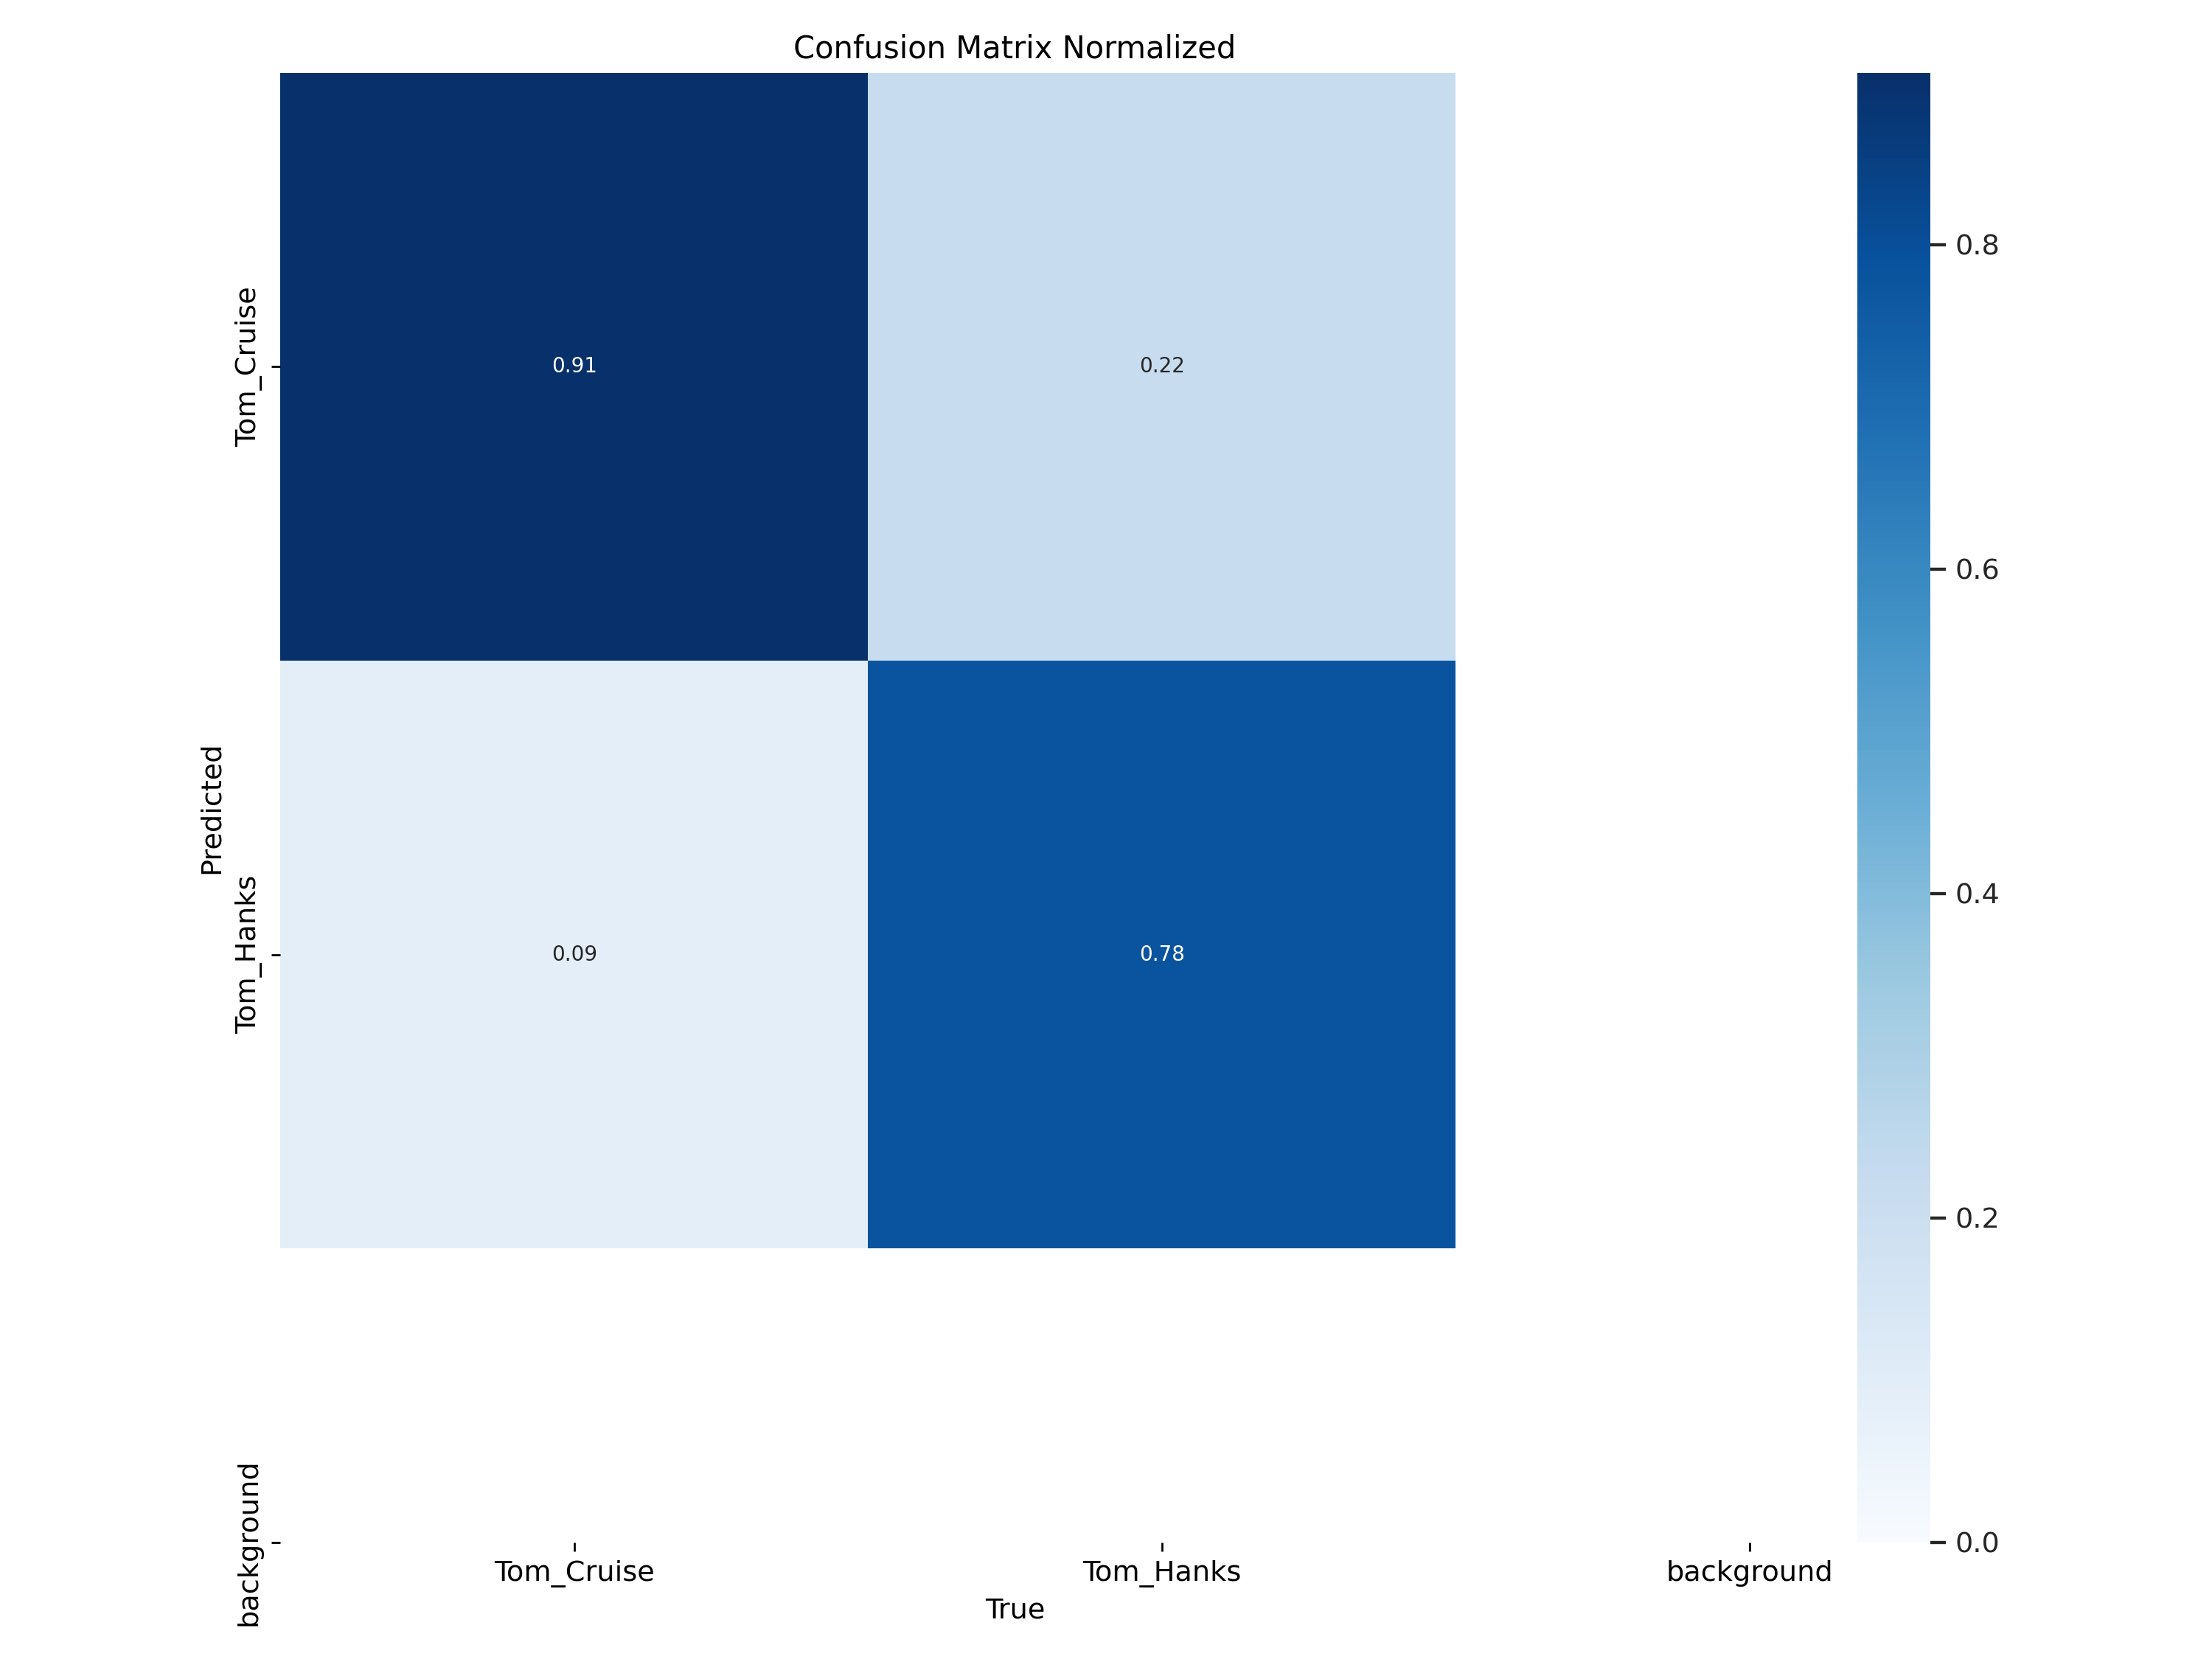

In [ ]:
Image("/content/runs/classify/yolo11s_cls_15N/confusion_matrix_normalized.png", width=800)

Результаты довольно странные, по одному классу видим ухудшение даже с младшей моделью

Попробуем заморозить:

In [ ]:
model = YOLO('yolo11s-cls.pt')

In [ ]:
# @title Текущее потребление памяти
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Максимальный объем памяти = {max_memory} ГБ.")
print(f"{start_gpu_memory} ГБ памяти зарезервировано.")

GPU = Tesla T4. Максимальный объем памяти = 14.741 ГБ.
3.041 ГБ памяти зарезервировано.


In [ ]:
start_time = time.time()
results = model.train(data='/content/dataset/classification_dataset', epochs=10, imgsz=224, name="yolo11s_cls_15N_f9", freeze=9)
train_runtime = time.time() - start_time

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolo11s-cls.pt, data=/content/dataset/classification_dataset, epochs=10, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11s_cls_15N_f92, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=9, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

AMP: checks passed ✅


train: Scanning /content/dataset/classification_dataset/train... 30 images, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
val: Scanning /content/dataset/classification_dataset/val... 177 images, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/yolo11s_cls_15N_f92
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.328          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all       0.35          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.367          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.418          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.503          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.571          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.672          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.718          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.729          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1307: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/block.py:1309: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but

                   all      0.746          1



10 epochs completed in 0.005 hours.
Optimizer stripped from runs/classify/yolo11s_cls_15N_f92/weights/last.pt, 11.0MB
Optimizer stripped from runs/classify/yolo11s_cls_15N_f92/weights/best.pt, 11.0MB

Validating runs/classify/yolo11s_cls_15N_f92/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-cls summary (fused): 47 layers, 5,436,690 parameters, 0 gradients, 12.0 GFLOPs
train: /content/dataset/classification_dataset/train... found 30 images in 2 classes ✅ 
val: /content/dataset/classification_dataset/val... found 177 images in 2 classes ✅ 
test: None...


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:260: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:265: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this o

                   all       0.74          1
Speed: 0.3ms preprocess, 1.0ms inference, 0.1ms loss, 0.0ms postprocess per image
Results saved to runs/classify/yolo11s_cls_15N_f92


In [ ]:
# @title Потребление памяти после обучения
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_training = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
training_percentage = round(used_memory_for_training / max_memory * 100, 3)

# Выводим статистику
print(f"{train_runtime} секунд затрачено на обучение.")
print(
    f"{round(train_runtime/60, 2)} минут затрачено на обучение."
)
print(f"Пиковый объем зарезервированной памяти = {used_memory} ГБ.")
print(f"Пиковый объем зарезервированной памяти для обучения = {used_memory_for_training} ГБ.")
print(f"Пиковый объем зарезервированной памяти в % от максимальной памяти = {used_percentage} %.")
print(f"Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = {training_percentage} %.")

22.65615940093994 секунд затрачено на обучение.
0.38 минут затрачено на обучение.
Пиковый объем зарезервированной памяти = 3.041 ГБ.
Пиковый объем зарезервированной памяти для обучения = 0.0 ГБ.
Пиковый объем зарезервированной памяти в % от максимальной памяти = 20.63 %.
Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = 0.0 %.


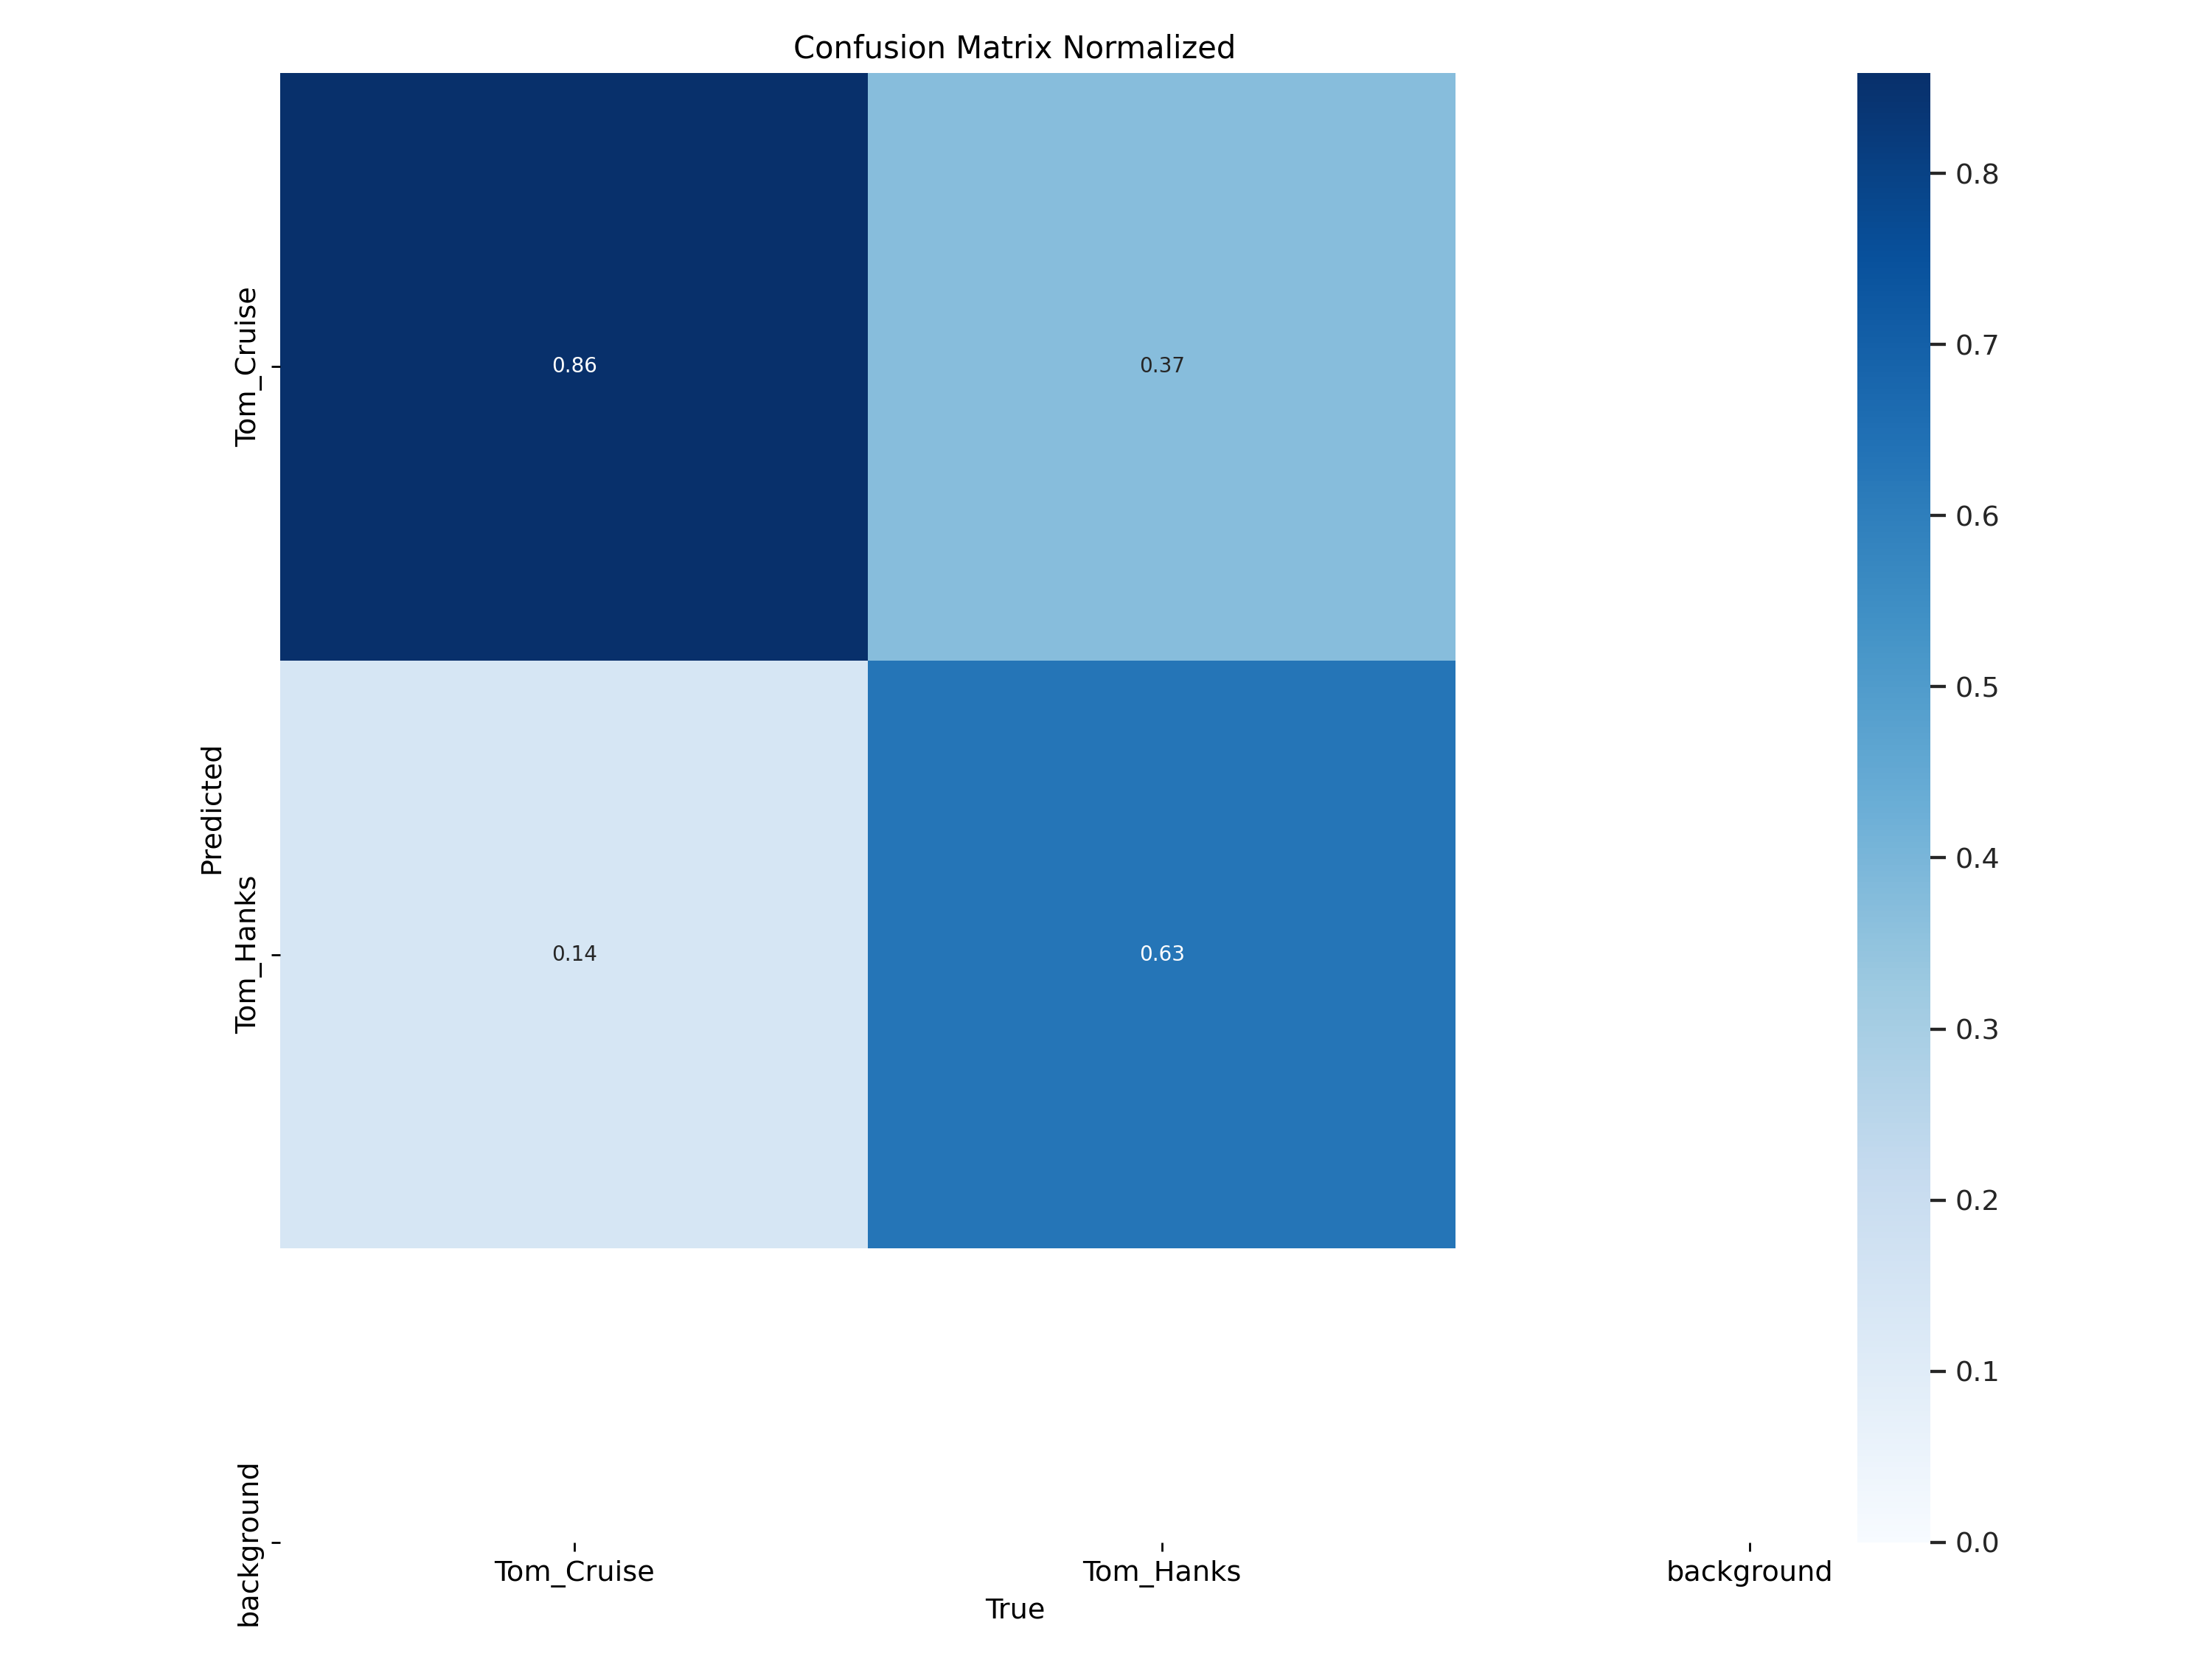

In [ ]:
Image("/content/runs/classify/yolo11s_cls_15N_f9/confusion_matrix_normalized.png", width=800)

Результаты стали хуже

# Вывод

Модели Yolo обучались без помощи аугментации и с помощью стандратного способа обучения предложенном авторами, при этом результаты сопоставимы с базовой моделю EfficentNet, с тем же временем обучения, но увы, результаты сильно разнятся в зависимости от выбранной модели и данных, к тому же, Transfer Learning лишь ухудшил обобщающую способность модели. ([Catastrophic interference](https://en.wikipedia.org/wiki/Catastrophic_interference))

Модели имеют гораздо более сложную архитектуру нежели чем компактные EfficentNet, и из-за этого интерпретируемость и возможноть предугадать результат ниже.

В связи с этим была выбрана малая версия модели EfficentNet B0

# Сохранение модели

In [ ]:
# Сохранение модели
torch.save(model, '/content/trained_model_classification.pt')

# Копирование на Google Drive
!cp "/content/trained_model_classification.pt" "/content/drive/MyDrive/classification/trained_model_classification.pt"
print("Модель сохранена")